# Assessment 2
During the covid pandemic, governments tried to predict the levels of infection so that they could manage the required infrastructure, especially hospital beds and (sadly) mortuary places. In this mini-project, you will take data from two different, publicly available, sources and try to see how well you could have done if you had been working for the UK government.  One of the sources is the UK data from the period and the other is google’s data on our behaviour during the pandemic.

You will use data up to a specific date to predict hospital beds needed, and deaths that will occur  in one, two, three and four weeks from that date.  You will do this for the whole pandemic period i.e. using a rolling  window. You will also quantify how well your prediction works.

Things that you might want to consider in your analysis include:

- There will be a time lag between people’s  behaviour changing and the number of people requiring a hospital bed (and another between people requiring hospitalisation and them dying).

- Both sources of data will have information that is  of no use to you and you will have to investigate those sources that are useful to you. You should start by thinking this through and then trying the effect of different variables.

- Both data sets may require some cleaning and (perhaps) some smoothing to remove effects such as weekends etc.

- As the situation changed some aspects of the older data nay or may not continue to be useful.  

- You may wish to do this by region or for the whole country, or even to compare the two.

We will provide you with basic code to access the data. It is up to you if you use it or not.


In [1]:
import os
import pandas as pd
pd.reset_option('display.max_rows')
path = '/home/fs1620/MLBD_2024_25/DA_ML/Assessments/Assessment_2/covid_19_archive/'
os.chdir(path)
print("Current working directory:", os.getcwd())

Current working directory: /home/fs1620/MLBD_2024_25/DA_ML/Assessments/Assessment_2/covid_19_archive


## 1. Setup

In [88]:
import pandas as pd
import datetime as dt
import numpy as np

import matplotlib.pylab as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
#Show plots inline
%matplotlib inline

#Some date formatters to use for plotting 
weeks = mdates.WeekdayLocator()
years = mdates.YearLocator()
months = mdates.MonthLocator()
weekdays = mdates.DayLocator()
dateFmt = mdates.DateFormatter('%b-%y')

# Some other libraries and modules we will use here
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
from tqdm import tqdm
from scipy.stats import randint, uniform

In [89]:
#seaborn is a useful package for handling graphics and 
#producing publication quality images with better colour schemes
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("talk")
#sns.set(font_scale=1.5) 
#sns.set_context("poster")

plt.rcParams.update({'font.size': 32})
plt.rcParams.update({'lines.linewidth':3})

## 2. Predictors (Section - 0)

In principle, covid cases, hospital admissions, and deaths are time-lagged outcomes of covariates or "predictor variables" such as the level of interactions in the population, mobility metrics, levels of restrictions etc.

A data set which is often used as a possible predictor is google mobility metrics https://www.google.com/covid19/mobility/.

In [4]:
#Import the data from Google.
#This is a large file!
# df_google = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')

**Farhan:** I have already read in the above file, performed the pre-processing steps below, and saved it locally for faster read-in.

In [5]:
#Select `United Kingdom` from the full data.
# df_google = df_google[df_google['country_region']=='United Kingdom']
# #Discard sub regions
# #Note - we England vs UK
# df_google = df_google[df_google['sub_region_1'].isnull()]
# display(df_google)

**Farhan:** The above step of preprocessing (from the given code) was completed previously, so no need to do it again.

In [6]:
#Re-index by date
# df_google.set_index(pd.to_datetime(df_google['date']),inplace=True)
# df_google.sort_index(inplace=True)
# df_google.columns
# display(df_google)

**Farhan:** This step of pre-processing is from the code that was given. I used this later to re-index the DataFrame, after I had filtered out the necessary columns:

In [7]:
# print(df_google.isna().sum()) # -> All the sub-region entries seem to be NaN
# #So, drop them
# df_google_me = df_google.drop(columns = ['sub_region_1',
#                                          'sub_region_2',
#                                          'metro_area',
#                                          'iso_3166_2_code',
#                                          'census_fips_code'])
# display(df_google_me)
# print(df_google_me.isna().sum()) # -> Now, no NaN's

**Farhan:** The above cell filtered out the sub-region info from the DataFrame, which seemed to have `NaN`'s for all entries. I saved this filtered DataFrame locally:

In [8]:
# df_google_me.to_csv('Google_locations_df_filtered.csv', sep=',', index=False, encoding='utf-8')

**Farhan:** From now, I'll read-in the filtered DataFrame, which was saved to disk. I also used the code above to re-index the read-in DataFrame here.

In [150]:
#df_google = pd.read_csv('Google_locations_df_filtered.csv', sep = ',') # Note: still has 'date' column
df_google = df_google_me.copy()
#display(df_google)
df_google.set_index(pd.to_datetime(df_google['date']),inplace=True)
df_google.sort_index(inplace = True)
# 'Date' appears twice, can drop the column, and retain the index
df_google = df_google.drop(columns = ['date', 'place_id', 'country_region_code', 'country_region']) 
#df_google_resampled = df_google.resample('W').mean() # resample weekly for later use
display(df_google) # -> Dates only appear as indices

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,
2020-02-15,-12.0,-7.0,-35.0,-12.0,-4.0,2.0
2020-02-16,-7.0,-6.0,-28.0,-7.0,-3.0,1.0
2020-02-17,10.0,1.0,24.0,-2.0,-14.0,2.0
2020-02-18,7.0,-1.0,20.0,-3.0,-14.0,2.0
2020-02-19,6.0,-2.0,8.0,-4.0,-14.0,3.0
...,...,...,...,...,...,...
2022-10-11,-11.0,7.0,29.0,-21.0,-24.0,5.0
2022-10-12,-11.0,6.0,16.0,-22.0,-24.0,5.0
2022-10-13,-9.0,9.0,30.0,-21.0,-24.0,5.0


Plot up some of the metrics. (**Farhan:** I packaged this into a plotting function later.)

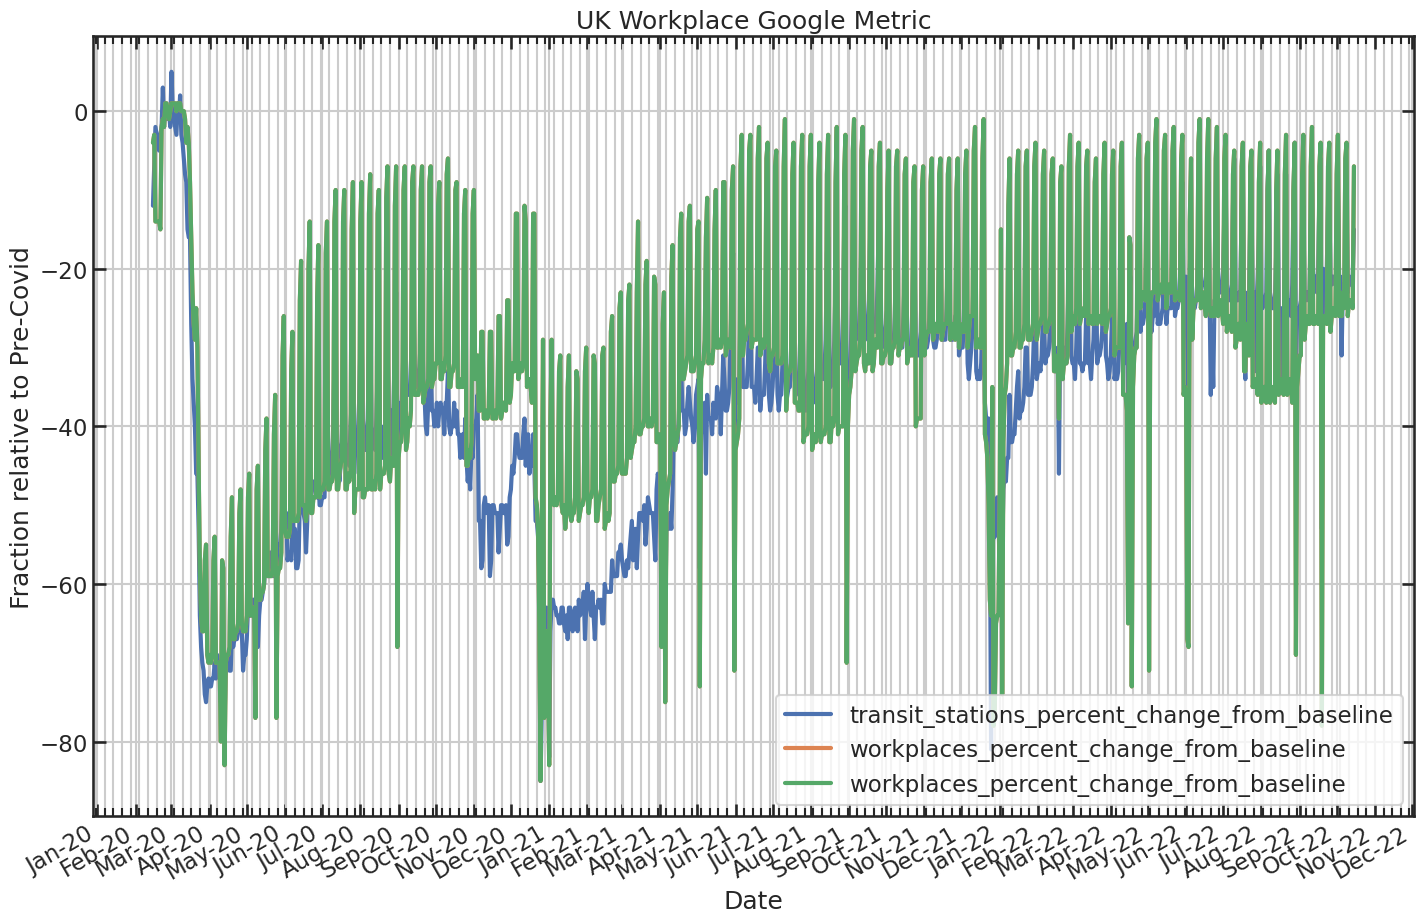

In [151]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')
# Can slice the list of columns any way we want to plot the info we want
for column in df_google.columns[[3,4,-2]]:
    ax.plot(df_google.index,df_google[column],label=f'{column}')

ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction relative to Pre-Covid')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax.set_title('UK Workplace Google Metric')
ax.legend()

_ = fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('mobility.png')

**Farhan:** Obviously, the same data is extracted and plotted from the filtered DataFrame. We note that the Google dataset gives information about the behvaiour of people and changes in it, as time progresses.

## The UK data from the covid period.

The UK data is available as a zip file from:

https://ukhsa-dashboard.data.gov.uk/covid-19-archive-data-download

this then needs to be unzipped 
```console
unzip  covid-19-archive.zip
```
This should produce a series of directories:
```console
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Cases
-rw-r--r--. 1 collngdj collngdj 1592889236 Oct 25 16:07 covid-19-archive.zip
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Deaths
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Healthcare
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Testing
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Vaccinations
```

Each of these has a set of csv files arranged over different years.

The following code is an example of how you might want to read these in and concatenate them over different years.



In [11]:
import re
from enum import StrEnum, auto
import pathlib
import pandas as pd

class DataType(StrEnum):
    Cases = auto()
    Deaths = auto()
    Healthcare = auto()
    Testing = auto()
    Vaccinations = auto()


def csvconcat(datatype: DataType,
              metric: str | None = None,
              dataroot: str | pathlib.Path = pathlib.Path.cwd()) -> dict[str, pd.DataFrame]:
    """
    Get Pandas DataFrames from the UK COVID-19 .csv data, Concatenated across years.

    Args:
        datatype (DataType): Corresponds to the directory to scan use enum type above.
                             i.e. [DataType.Cases|DataType.Deaths|DataType.Healthcare|
                                   DataType.Testing|DataType.Vaccinations]
        metric (str | None, optional): Chose an individual metric to process. If None (the default) then all
                                       metrics for the given DataType are processed. Defaults to None.
        dataroot (pathlib.Path, optional): The root directory for the unpacked UK COVID-19 data.
                                           DataType directories (Cases/Deaths) etc should be under this root.
                                           Defaults to pathlib.Path.cwd().
    Raises:
        ValueError: If there is a failure to convert the given dataroot to a Path object.

    Returns:
        dict[str, pd.DataFrame]: The mapping from metric to fully concatenated DataFrame.
    """
    if not isinstance(dataroot, pathlib.Path):
        try:
            dataroot = pathlib.Path(dataroot)
        except:
            raise ValueError(f"dataroot: '{dataroot}' could not be converted to a Path.")

    dataroot /= datatype.name
    metric_regex = re.compile(r"(?P<metric>\w+?)_(?P<specifier>nation|region|utla|ltla|overview)_20\d\d.csv")
    metrics: set[str] = {str(metric)}
    if metric is None:
        file_list = (file_.relative_to(dataroot).name for file_ in dataroot.rglob("*.csv"))
        metrics = {match.group("metric") for file_ in file_list if (match := metric_regex.match(file_))}

    ret = {}
    for current_metric in metrics:
        ret.update({current_metric: pd.concat(pd.read_csv(file_) for file_ in dataroot.rglob(f"{current_metric}_*.csv"))})

    return ret

In [12]:
# Get a specific metric
data = csvconcat(DataType.Healthcare, "newAdmissions")
display(data['newAdmissions'])

,date,area_type,area_code,area_name,metric,metric_name,value
0,2020-06-01,overview,K02000001,United Kingdom,newAdmissions,New admissions,605.0
1,2020-06-02,overview,K02000001,United Kingdom,newAdmissions,New admissions,666.0
2,2020-06-03,overview,K02000001,United Kingdom,newAdmissions,New admissions,632.0
3,2020-06-04,overview,K02000001,United Kingdom,newAdmissions,New admissions,562.0
4,2020-06-05,overview,K02000001,United Kingdom,newAdmissions,New admissions,472.0
...,...,...,...,...,...,...,...
249,2022-09-07,overview,K02000001,United Kingdom,newAdmissions,New admissions,608.0
250,2022-09-08,overview,K02000001,United Kingdom,newAdmissions,New admissions,586.0
251,2022-09-09,overview,K02000001,United Kingdom,newAdmissions,New admissions,490.0
252,2022-09-10,overview,K02000001,United Kingdom,newAdmissions,New admissions,451.0


In [13]:
# Get all metrics for a DataType
data = csvconcat(DataType.Healthcare)
print(f"Data contains {len(data)} concatenated metrics")
print(f"Checking our chosen metric 'transmissionRateGrowthRateMax' is found in data: {'transmissionRateGrowthRateMax' in data}")
print("Available metrics:")
print(list(data.keys()))

Data contains 25 concatenated metrics
Checking our chosen metric 'transmissionRateGrowthRateMax' is found in data: True
Available metrics:
['hospitalCases_archive', 'transmissionRateGrowthRateMax', 'hospitalCasesWeekly_archive', 'transmissionRateMax', 'newAdmissions_archive', 'transmissionRateGrowthRateMin', 'newAdmissionsWeekly_archive', 'hospitalCasesWeekly', 'covidOccupiedMVBeds', 'newAdmissionsDirection', 'newAdmissionsByAge', 'cumAdmissionsRate', 'newAdmissionsRollingSum', 'cumAdmissions_archive', 'cumAdmissions', 'covidOccupiedMVBedsWeekly', 'alertLevel', 'newAdmissionsChangePercentage', 'newAdmissionsWeekly', 'cumAdmissionsByAge', 'newAdmissionsRollingRate', 'transmissionRateMin', 'hospitalCases', 'newAdmissions', 'newAdmissionsChange']


The first thing that you might want to play around with is trying to plot some of these data and comparing them to the different predictors.

# CID: 01876355
## Section-1: Data clean-up and pre-processing

### 1.1 Government Data

We will start our investigation in the 'Healthcare' folder. The dataframes in the 'Healthcare' folder are: `['newAdmissionsChangePercentage', 'cumAdmissionsByAge', 'newAdmissionsByAge', 'hospitalCasesWeekly_archive',   'transmissionRateGrowthRateMin', 'covidOccupiedMVBedsWeekly', 'newAdmissions_archive',   'newAdmissionsRollingSum', 'cumAdmissionsRate', 'transmissionRateGrowthRateMax',   'hospitalCasesWeekly', 'hospitalCases', 'newAdmissionsRollingRate', 'newAdmissionsDirection', 'newAdmissions',   'newAdmissionsWeekly_archive', 'newAdmissionsChange', 'hospitalCases_archive', 'transmissionRateMax', 'alertLevel', 'newAdmissionsWeekly', 'transmissionRateMin', 'cumAdmissions_archive', 'covidOccupiedMVBeds', 'cumAdmissions']`.

From playing around with the dataframes above, we have identified that the relevant dataframes in this folder are: `'covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions'`, given our goals of using past data to predict the number of beds needed in a week's time, two weeks' time, etc. Our first step will be to try and predict the number of beds needed, and then we will extend our model to also try and predict the number of deaths that are likely to occur, as well as incorporating other relevant features, such as number of vaccinations and covid tests, etc.

We note that, files labelled 'archive' only contain info on Northern Ireland (do we want to focus on this region in particular?) and already seem to be contained in the corresponding 'un-archived' files.

We will need to format all our datasets of interest into a form containing relevant information only, which is the data contained in the 'value' columns of the dataframes. A major problem here is that different files contain data collected over different time ranges, and we want to have access to data that covers the entire covid pandemic period - roughly from the start of 2020 to just before the end of 2022, taking somewhat of an overestimate. 

We will start with the 'newAdmissions' files. We'll first rename our chosen DataFrame, after selecting the entries labelled 'nation'. We will start our investigation using those entries and ensure to remove duplicate entries, if there are any. 

Then, we will re-index and sort by 'date' (after converting it to `DateTime` format) and remove entries labelled 'archive' from the dataset (if there are any), since we are not interested in these for now. We will also want to ensure that the any invalid dates are that may show up in the conversion process are correctly handled.

We note that the entries labelled 'overview' contain pretty much the same data, albeit covering a smaller date range, as the 'nation' files after summing over all the data in the 'value' columns of these files for a given date (found this by just playing around with the data). We can use the extra information going forward, so we'll sum over entries on a given date for the 'nation' files. 

More generally, we might be interested in retaining several columns, so, we will make a slight adjustment for this.

We will write a `reformatter` function that performs this series of steps automatically for any input `metric` DataFrame:

In [14]:
def reformatter(data, metric, area_type, columns_to_keep):
    data_metric = data[metric]
    data_area = data_metric[data_metric['area_type'] == area_type].copy()
    data_area = data_area.drop_duplicates()
    data_area['date'] = pd.to_datetime(data_area['date'], errors='coerce')
    data_area = data_area.dropna(axis=0, subset=['date'])
    data_area = data_area.set_index('date').sort_index()
    data_filter = data_area[~data_area['metric'].str.contains('archive', case=False, na=False)]
    data_filter = data_filter.groupby(pd.Grouper(freq='D')).sum()
    data_filter = data_filter[columns_to_keep]
    return data_filter

A quick check on an important metric we'll look at:

In [15]:
data_healthcare = csvconcat(DataType.Healthcare)
display(reformatter(data_healthcare, 'covidOccupiedMVBeds', 'nation', ['value']))

,value
date,
2020-06-01,652.0
2020-06-02,636.0
2020-06-03,602.0
2020-06-04,571.0
2020-06-05,554.0
...,...
2023-07-08,0.0
2023-07-09,0.0
2023-07-10,0.0


Now, we'll combine the relevant information contained in the three metrics we identified to be useful, and perform some preliminary visual analysis to see if we can find any noticable trends. We'll write a `combiner` function to do this:

In [16]:
def combiner(dataframes):
    combined_df = pd.concat(dataframes, axis=1)
    return combined_df

Lastly, we will rename the 'value' column to something more identifiable such as 'newAdmissions'. Again, since the data from each dataframe covers different date ranges, we'll need to drop `NaN`'s from the `combined` DataFrame. Check:

In [17]:
chosen_metrics = ['covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions']
filtered_df_list = []
for chosen_metric in chosen_metrics:
    filtered_df_list.append(reformatter(data_healthcare, chosen_metric, 'nation', ['value']))
combined = combiner(filtered_df_list)
combined.dropna(axis = 0, inplace = True)
combined.columns = chosen_metrics
display(combined)

,covidOccupiedMVBeds,hospitalCases,newAdmissions
date,,,
2020-06-01,652.0,7171.0,605.0
2020-06-02,636.0,7014.0,666.0
2020-06-03,602.0,6750.0,632.0
2020-06-04,571.0,6525.0,562.0
2020-06-05,554.0,6325.0,472.0
...,...,...,...
2023-07-08,0.0,1154.0,115.0
2023-07-09,0.0,1154.0,129.0
2023-07-10,0.0,1148.0,165.0


We expect to be plotting the trends in many parameters, so we might require aspects of the plot to be fine tuned. We'll make a function to do the plotting:

In [18]:
def trend_plotter(cols, data, leg_params = [True, 20]):
    # Included a leg_params input parameter
    # Nice for plotting a lot of data, without overlapping legend
    fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

    for col in cols:
        ax.plot(data.index, data[col], label=col)
    ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)
    ax.grid(which='both')
    ax.set_xlabel('Date')
    ax.set_ylabel('Raw Counts')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(dateFmt)
    ax.xaxis.set_minor_locator(weeks)
    ax.set_title(f'Daily Reported Metrics Over the Pandemic')
    if leg_params[0] == True:
        ax.legend(fontsize = leg_params[1])
    
    _ = fig.autofmt_xdate()
    
    plt.tight_layout()

Now, we can visualise how these features vary over time:

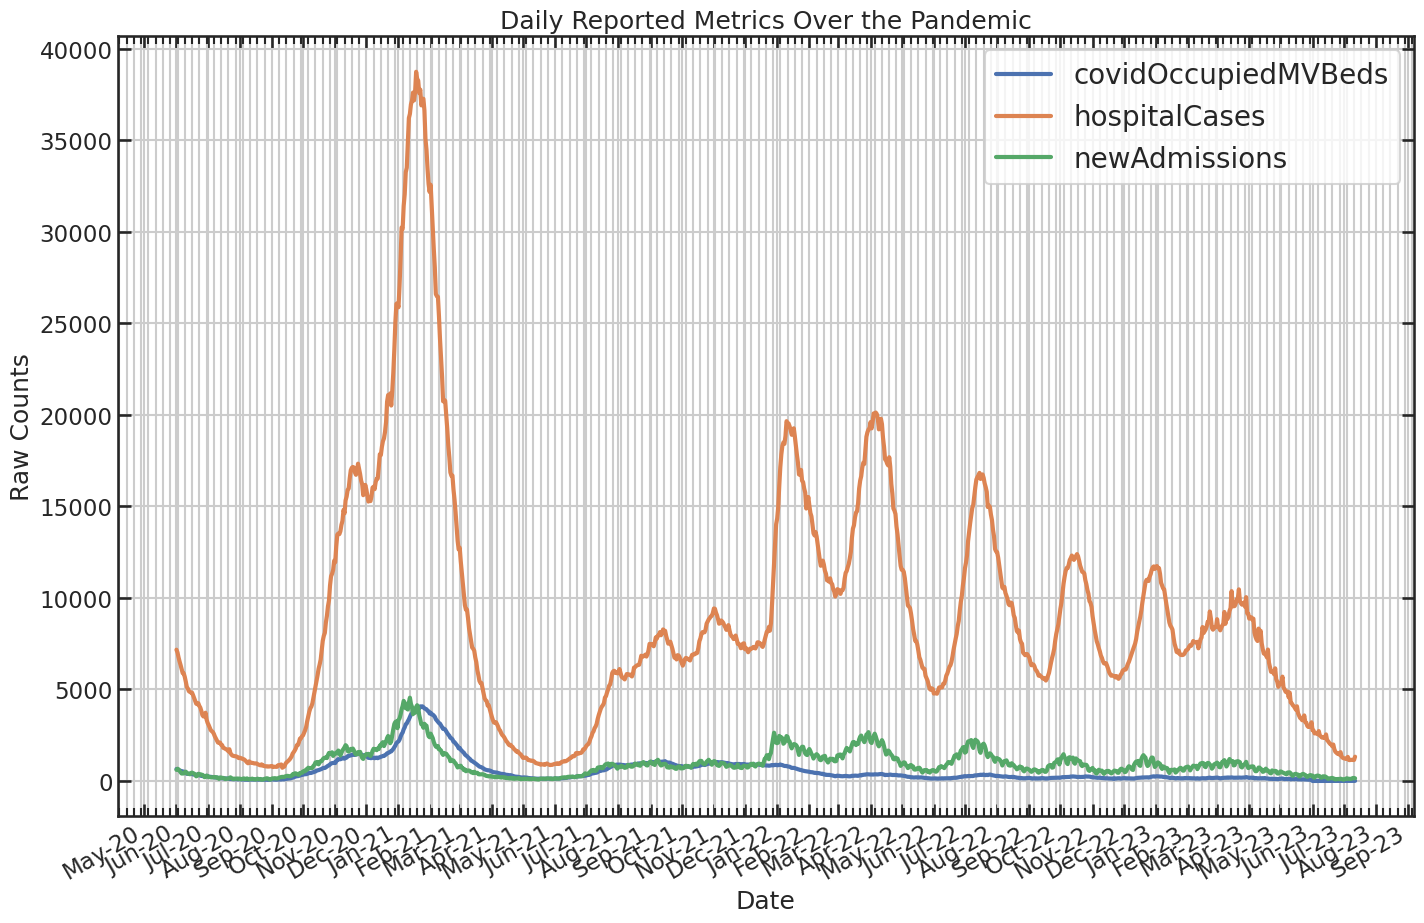

In [19]:
trend_plotter(combined.columns, combined, [True, 20])

### 1.2 Google Data
Before we incorporate the data from Google, we'll need to perform some pre-processing on it as well, since it doesn't seem to account for 'weekend effects' and shows a lot of fluctuations:

In [20]:
display(df_google)

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,
2020-02-15,-12.0,-7.0,-35.0,-12.0,-4.0,2.0
2020-02-16,-7.0,-6.0,-28.0,-7.0,-3.0,1.0
2020-02-17,10.0,1.0,24.0,-2.0,-14.0,2.0
2020-02-18,7.0,-1.0,20.0,-3.0,-14.0,2.0
2020-02-19,6.0,-2.0,8.0,-4.0,-14.0,3.0
...,...,...,...,...,...,...
2022-10-11,-11.0,7.0,29.0,-21.0,-24.0,5.0
2022-10-12,-11.0,6.0,16.0,-22.0,-24.0,5.0
2022-10-13,-9.0,9.0,30.0,-21.0,-24.0,5.0


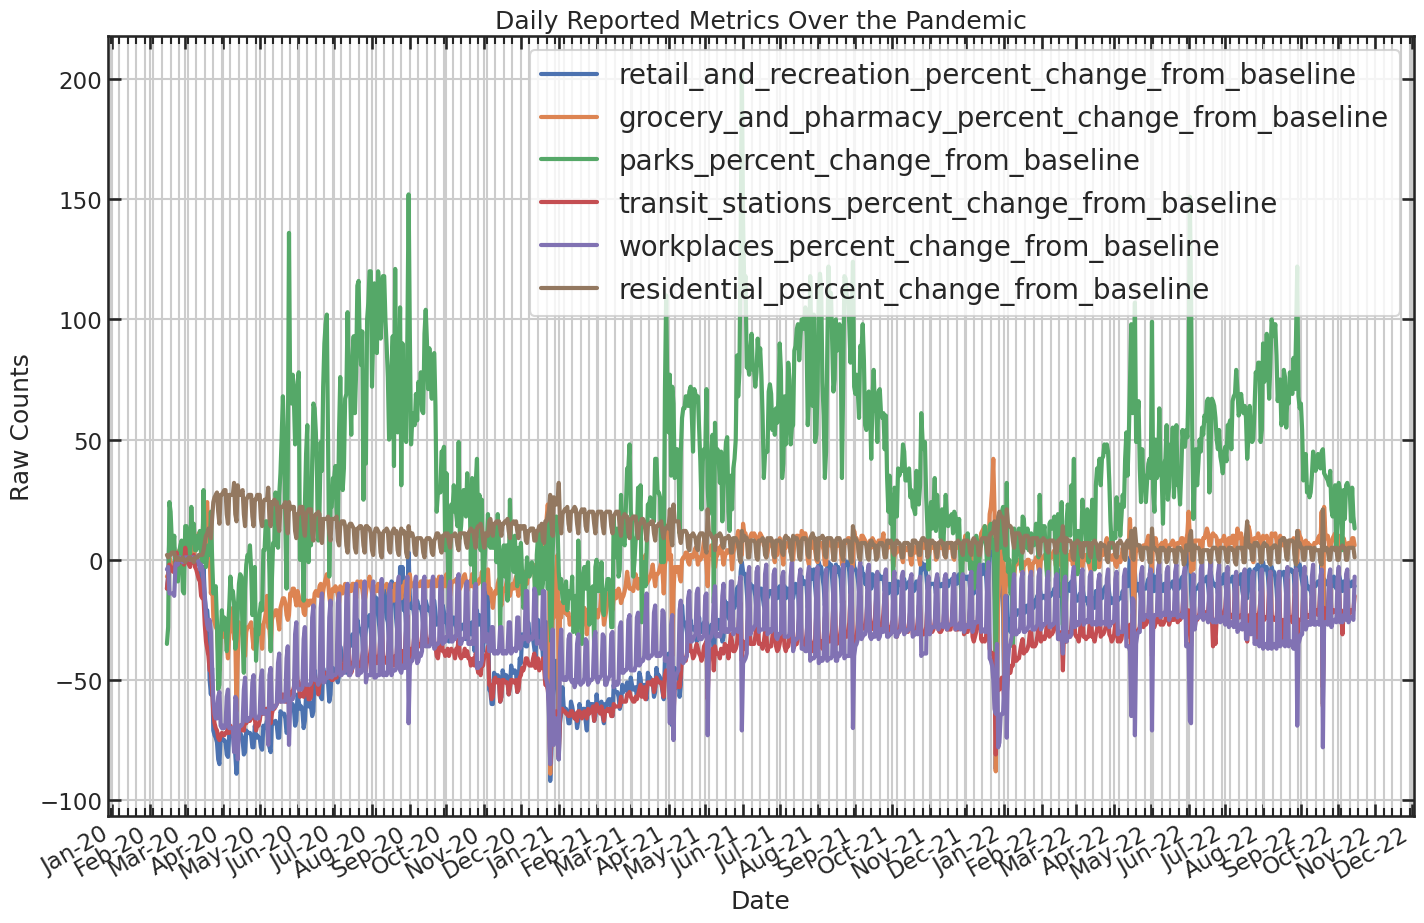

In [21]:
cols_google = df_google.columns[0:]
trend_plotter(cols_google, df_google)

Now, given the behavioural data obtained from Google, we need to make a distinction between weekday and weekend data, since, e.g., many people don't go to work on weekends anyways, so the number going to work would be less than during the week regardless. We can identify two approaches to dealing with this issue: we can either smooth the data to account for these weekend effects, or we can, effectively, one-hot encode our data to distinguish between our datapoints (**weekend** or **not weekend**).

Before we do that, we note that our index is in `DateTime` format: not good. ML algorithms can't work directly with this data type, so we'll need to introduce additional features that contain numerical information about the year, month, and day of the week (in terms of index: 0 = Monday, 6 = Sunday).

In [22]:
df_google['year'] = df_google.index.year
df_google['month'] = df_google.index.month
df_google['day'] = df_google.index.dayofweek
display(df_google)

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,year,month,day
date,,,,,,,,,
2020-02-15,-12.0,-7.0,-35.0,-12.0,-4.0,2.0,2020,2,5
2020-02-16,-7.0,-6.0,-28.0,-7.0,-3.0,1.0,2020,2,6
2020-02-17,10.0,1.0,24.0,-2.0,-14.0,2.0,2020,2,0
2020-02-18,7.0,-1.0,20.0,-3.0,-14.0,2.0,2020,2,1
2020-02-19,6.0,-2.0,8.0,-4.0,-14.0,3.0,2020,2,2
...,...,...,...,...,...,...,...,...,...
2022-10-11,-11.0,7.0,29.0,-21.0,-24.0,5.0,2022,10,1
2022-10-12,-11.0,6.0,16.0,-22.0,-24.0,5.0,2022,10,2
2022-10-13,-9.0,9.0,30.0,-21.0,-24.0,5.0,2022,10,3


To implement the **second** approach noted above, we'll introduce other features that distinguishes between weekday/weekend data:

In [23]:
df_google_ohe = df_google.copy()
df_google_ohe['weekday/weekend'] = df_google_ohe.day.map(lambda x: 1 if x<5 else 0)
df_google_ohe['weekday'] = df_google_ohe['weekday/weekend']
df_google_ohe['weekend'] = 1 - df_google_ohe['weekday']
df_google_ohe.drop(columns=['weekday/weekend', 'weekday'], inplace=True)
display(df_google_ohe)

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,year,month,day,weekend
date,,,,,,,,,,
2020-02-15,-12.0,-7.0,-35.0,-12.0,-4.0,2.0,2020,2,5,1
2020-02-16,-7.0,-6.0,-28.0,-7.0,-3.0,1.0,2020,2,6,1
2020-02-17,10.0,1.0,24.0,-2.0,-14.0,2.0,2020,2,0,0
2020-02-18,7.0,-1.0,20.0,-3.0,-14.0,2.0,2020,2,1,0
2020-02-19,6.0,-2.0,8.0,-4.0,-14.0,3.0,2020,2,2,0
...,...,...,...,...,...,...,...,...,...,...
2022-10-11,-11.0,7.0,29.0,-21.0,-24.0,5.0,2022,10,1,0
2022-10-12,-11.0,6.0,16.0,-22.0,-24.0,5.0,2022,10,2,0
2022-10-13,-9.0,9.0,30.0,-21.0,-24.0,5.0,2022,10,3,0


This is good since it will let our model know to make a distinction between weekday/end data. However, this comes at the cost of some interpretability on the side of the user. This is especially true if we try to plot the data displayed immediately above, since we will just get the same plot as we did previously, because we have not applied any sort of smoothing. 

The first approach noted above, does just this. We can smooth our data using a few methods. The simplest method might be to replace the weekend values with `NaN`'s and then fill them in using `interpolate()` and `ffill()`/`bfill()`. Alternatively, we could adopt a rolling window method. These are implemented as follows:

In [24]:
df_google_smooth = df_google.copy()
display(df_google_smooth)
df_google_smooth['is_weekend'] = df_google_smooth.index.dayofweek >= 5
# The above line adds a column at the end of the dataframe
# Need index to end at -4 instead of -3:
columns_to_smooth = [col for col in df_google_smooth.columns[0:-4]]

# This block implements linear interpolation and forward/backward fills to apply smoothing

for col in columns_to_smooth:
    df_google_smooth.loc[df_google_smooth['is_weekend'], col] = np.nan

df_google_smooth[columns_to_smooth] = df_google_smooth[columns_to_smooth].interpolate(method='linear', axis=0)
df_google_smooth[columns_to_smooth] = df_google_smooth[columns_to_smooth].ffill().bfill()

#This block implements a rolling window over the weekend to apply smoothing

# for col in columns_to_smooth:
#     df_google_smooth.loc[df_google_smooth['is_weekend'], col] = np.nan
#     df_google_smooth[col] = df_google_smooth[col].rolling(window=3, center=True, min_periods=1).mean()
    
df_google_smooth[columns_to_smooth] = df_google_smooth[columns_to_smooth].ffill().bfill()
df_google_smooth.drop(columns='is_weekend', inplace=True)

display(df_google_smooth)

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,year,month,day
date,,,,,,,,,
2020-02-15,-12.0,-7.0,-35.0,-12.0,-4.0,2.0,2020,2,5
2020-02-16,-7.0,-6.0,-28.0,-7.0,-3.0,1.0,2020,2,6
2020-02-17,10.0,1.0,24.0,-2.0,-14.0,2.0,2020,2,0
2020-02-18,7.0,-1.0,20.0,-3.0,-14.0,2.0,2020,2,1
2020-02-19,6.0,-2.0,8.0,-4.0,-14.0,3.0,2020,2,2
...,...,...,...,...,...,...,...,...,...
2022-10-11,-11.0,7.0,29.0,-21.0,-24.0,5.0,2022,10,1
2022-10-12,-11.0,6.0,16.0,-22.0,-24.0,5.0,2022,10,2
2022-10-13,-9.0,9.0,30.0,-21.0,-24.0,5.0,2022,10,3


,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,year,month,day
date,,,,,,,,,
2020-02-15,10.0,1.0,24.0,-2.0,-14.0,2.0,2020,2,5
2020-02-16,10.0,1.0,24.0,-2.0,-14.0,2.0,2020,2,6
2020-02-17,10.0,1.0,24.0,-2.0,-14.0,2.0,2020,2,0
2020-02-18,7.0,-1.0,20.0,-3.0,-14.0,2.0,2020,2,1
2020-02-19,6.0,-2.0,8.0,-4.0,-14.0,3.0,2020,2,2
...,...,...,...,...,...,...,...,...,...
2022-10-11,-11.0,7.0,29.0,-21.0,-24.0,5.0,2022,10,1
2022-10-12,-11.0,6.0,16.0,-22.0,-24.0,5.0,2022,10,2
2022-10-13,-9.0,9.0,30.0,-21.0,-24.0,5.0,2022,10,3


Let us plot this data to see how the fluctuations have been modified:

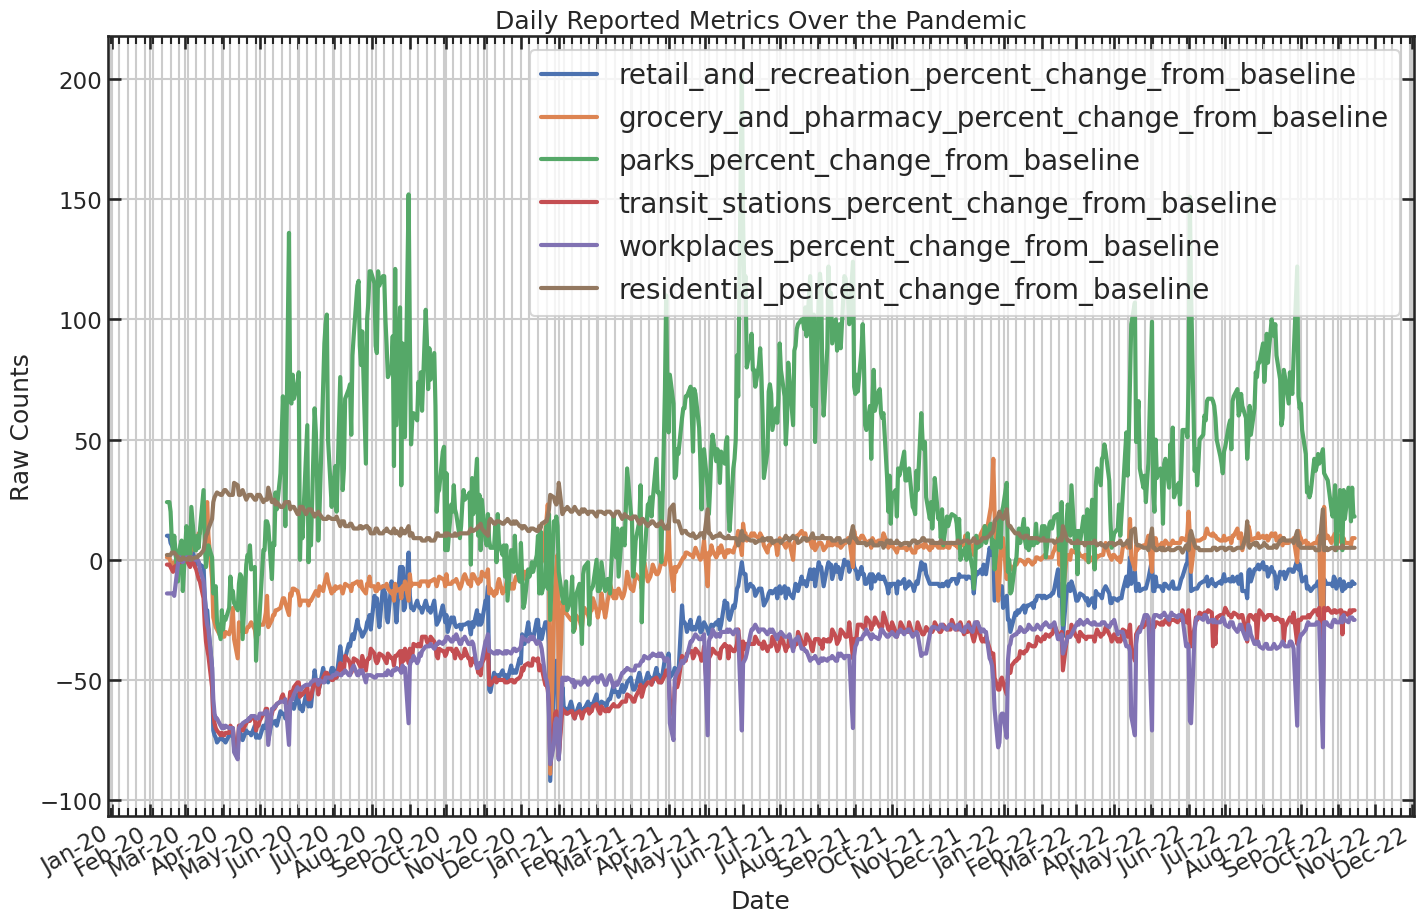

In [25]:
cols_smoothed = df_google_smooth.columns[0:-3]
trend_plotter(cols_smoothed, df_google_smooth)

As can be seen from the plot, most of the graphs have been smoothed out to a very large extent. Of course, there are still sudden spikes in places, but their number has been reduced.

Now, we have a choice as to which approach we adopt going forward. We pick the approach of labelling weekday/end entries as 0s/1s respectively, instead of the smoothing approach. We do this because this will help our model of choice to learn better, which is what is important, rather than human interpretability since the actual prediction will be performed by the model. Also, there is some possibility that the smoothing procedure is not entirely reliable, and that certain trends in the data may be completely removed, which would otherwise have been useful in our analysis. We may revisit the smoothing approach, if time permits.

At this point, I'll join the `df_google_ohe` dataframe to the `combined` dataframe:

In [26]:
new_list_overall = [combined, df_google_ohe]
combined_google = combiner(new_list_overall)
# For some reason the day and weekend columns get converted to float
combined_google.dropna(axis = 0, inplace = True)
combined_google[['day','weekend']] = combined_google[['day','weekend']].astype('int')
display(combined_google)

,covidOccupiedMVBeds,hospitalCases,newAdmissions,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,year,month,day,weekend
date,,,,,,,,,,,,,
2020-06-01,652.0,7171.0,605.0,-56.0,-13.0,74.0,-51.0,-53.0,19.0,2020.0,6.0,0,0
2020-06-02,636.0,7014.0,666.0,-59.0,-15.0,78.0,-51.0,-54.0,19.0,2020.0,6.0,1,0
2020-06-03,602.0,6750.0,632.0,-62.0,-19.0,0.0,-57.0,-54.0,22.0,2020.0,6.0,2,0
2020-06-04,571.0,6525.0,562.0,-61.0,-17.0,19.0,-56.0,-54.0,22.0,2020.0,6.0,3,0
2020-06-05,554.0,6325.0,472.0,-63.0,-17.0,9.0,-56.0,-53.0,22.0,2020.0,6.0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,241.0,12179.0,1243.0,-11.0,7.0,29.0,-21.0,-24.0,5.0,2022.0,10.0,1,0
2022-10-12,240.0,12314.0,1189.0,-11.0,6.0,16.0,-22.0,-24.0,5.0,2022.0,10.0,2,0
2022-10-13,248.0,12229.0,1276.0,-9.0,9.0,30.0,-21.0,-24.0,5.0,2022.0,10.0,3,0


Now, the key point is that we want to use the data available up to a certain date to predict how many beds will be needed. To this end, it might be useful to introduce some 'lagged' features that will help the model learn better. To find the duration of the lag between, say, people's behaviour changing and changes in hospital admissions, we need to perform a cross-correlation analysis between these two features. More generically, we can use this method to find how long it takes for the changes in one predictor variable to affect the target variable.

### 1.3 Cross-correlation analysis

We can find the correlation between how the number of hospital beds changes with changes in admissions and hospital cases, by lagging these last two features by different numbers of days. For each (predictor, target) pair this will produce a correlation function in terms of the lag. This is more thoroughly demonstrated below. Negative best lags imply using data from the future, which is clearly not allowed here, so we'll be looking for positive best lags. By best lags, we mean the rough maxima of the absolute value of the correlation functions between the (predictor, target) pair.

First we define a `crosscorr()` function to find the cross-correlation between variates and return the optimal lag in terms of days. We also define a function `crosscorr_plotter()` to plot the cross-correlation functions:

In [27]:
def crosscorr(trgt, prdctr, max_lag):
    correlations = [trgt.corr(prdctr.shift(lag)) for lag in range(-max_lag, max_lag+1)]
    best_lag = np.argmax(np.abs(correlations)) - max_lag
    return correlations, best_lag
def crosscorr_analyser(max_lag, pred, corrcalc, positive_lags, plotting):
    if corrcalc[1]>0:
        positive_lags.append([pred, corrcalc[1]])
        lag_range = range(-max_lag, max_lag+1)
        if plotting == True:
            plt.figure(figsize=(10, 6))
            plt.plot(lag_range, corrcalc[0], marker='o', label = f'Optimal lag: {corrcalc[1]}')
            plt.xlabel("Lag (days)")
            plt.ylabel("Correlation")
            plt.title(f"Correlation between #Beds and #{str.capitalize(pred)}")
            plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
            plt.grid()
            plt.legend()
            plt.show()
    
    else:
        pass
    return positive_lags

Now, we'll find the correlation between the number of beds, and all the predictors, and retain the positive best lags and the corresponding metrics:

In [28]:
max_lag = 30
behave_preds = [col for col in combined_google.iloc[:,1:-4].columns]
#print([col for col in combined_google.iloc[:,1:-4].columns])
beds = combined_google['covidOccupiedMVBeds']
lags = []
for index, pred in enumerate(behave_preds):
    corrcalc = crosscorr(beds, combined_google[pred], max_lag)
    positive_lags = crosscorr_analyser(max_lag, pred, corrcalc, lags, False)
print(f'The metrics with positive lags, and the corresponding lags are: {positive_lags}')

The metrics with positive lags, and the corresponding lags are: [['hospitalCases', 5], ['newAdmissions', 13], ['grocery_and_pharmacy_percent_change_from_baseline', 3], ['workplaces_percent_change_from_baseline', 7]]


From the above, we find that only 4 of the metrics have positive lags with the number of beds, so we'll apply these lags to the combined (one-hot encoded) DataFrame. We'll retain the unlagged DataFrame and compare the performance of our model on each DataFrame. 

It makes sense for the lagged dataframe to include `NaN`'s,since  they arise from the lagging procedure above. While we could fill them in using 0's, this may affect the model training. Then again, it seems somewhat reasonable to fill them in with 0's since the `NaN`'s all happen at the start of the DataFrame. We could try other approaches, such as using seasonal means, forward/backward fills, etc., but for now, we will fill these with 0s. 

In [29]:
combined_google_lagged = combined_google.copy()
for pairs in positive_lags:
    combined_google_lagged[pairs[0]+'_lagged'] = combined_google_lagged[pairs[0]].shift(pairs[1])
    combined_google_lagged.drop(columns = pairs[0], inplace = True)
combined_google_lagged.fillna(0, inplace = True)
display(combined_google_lagged)

,covidOccupiedMVBeds,retail_and_recreation_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,residential_percent_change_from_baseline,year,month,day,weekend,hospitalCases_lagged,newAdmissions_lagged,grocery_and_pharmacy_percent_change_from_baseline_lagged,workplaces_percent_change_from_baseline_lagged
date,,,,,,,,,,,,,
2020-06-01,652.0,-56.0,74.0,-51.0,19.0,2020.0,6.0,0,0,0.0,0.0,0.0,0.0
2020-06-02,636.0,-59.0,78.0,-51.0,19.0,2020.0,6.0,1,0,0.0,0.0,0.0,0.0
2020-06-03,602.0,-62.0,0.0,-57.0,22.0,2020.0,6.0,2,0,0.0,0.0,0.0,0.0
2020-06-04,571.0,-61.0,19.0,-56.0,22.0,2020.0,6.0,3,0,0.0,0.0,-13.0,0.0
2020-06-05,554.0,-63.0,9.0,-56.0,22.0,2020.0,6.0,4,0,0.0,0.0,-15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,241.0,-11.0,29.0,-21.0,5.0,2022.0,10.0,1,0,11460.0,1166.0,6.0,-24.0
2022-10-12,240.0,-11.0,16.0,-22.0,5.0,2022.0,10.0,2,0,11635.0,1184.0,3.0,-26.0
2022-10-13,248.0,-9.0,30.0,-21.0,5.0,2022.0,10.0,3,0,11630.0,903.0,7.0,-23.0


In [30]:
display(combined_google)

,covidOccupiedMVBeds,hospitalCases,newAdmissions,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,year,month,day,weekend
date,,,,,,,,,,,,,
2020-06-01,652.0,7171.0,605.0,-56.0,-13.0,74.0,-51.0,-53.0,19.0,2020.0,6.0,0,0
2020-06-02,636.0,7014.0,666.0,-59.0,-15.0,78.0,-51.0,-54.0,19.0,2020.0,6.0,1,0
2020-06-03,602.0,6750.0,632.0,-62.0,-19.0,0.0,-57.0,-54.0,22.0,2020.0,6.0,2,0
2020-06-04,571.0,6525.0,562.0,-61.0,-17.0,19.0,-56.0,-54.0,22.0,2020.0,6.0,3,0
2020-06-05,554.0,6325.0,472.0,-63.0,-17.0,9.0,-56.0,-53.0,22.0,2020.0,6.0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,241.0,12179.0,1243.0,-11.0,7.0,29.0,-21.0,-24.0,5.0,2022.0,10.0,1,0
2022-10-12,240.0,12314.0,1189.0,-11.0,6.0,16.0,-22.0,-24.0,5.0,2022.0,10.0,2,0
2022-10-13,248.0,12229.0,1276.0,-9.0,9.0,30.0,-21.0,-24.0,5.0,2022.0,10.0,3,0


Given these features, and taking the number of occupied hospital beds as the target variable, we can start building a simple model that tries to predict the number of hospital beds required after a certain time, by training it on the data available up to that point.

## Section 2: Rolling Window Forecasting

Before we start constructing a basic model, let us perform a quick check to see if our data is usable (i.e. doesn't contain `NaN`'s):

In [31]:
print(combined_google.isna().sum())

covidOccupiedMVBeds                                   0
hospitalCases                                         0
newAdmissions                                         0
retail_and_recreation_percent_change_from_baseline    0
grocery_and_pharmacy_percent_change_from_baseline     0
parks_percent_change_from_baseline                    0
transit_stations_percent_change_from_baseline         0
workplaces_percent_change_from_baseline               0
residential_percent_change_from_baseline              0
year                                                  0
month                                                 0
day                                                   0
weekend                                               0
dtype: int64


In [32]:
print(combined_google_lagged.isna().sum())

covidOccupiedMVBeds                                         0
retail_and_recreation_percent_change_from_baseline          0
parks_percent_change_from_baseline                          0
transit_stations_percent_change_from_baseline               0
residential_percent_change_from_baseline                    0
year                                                        0
month                                                       0
day                                                         0
weekend                                                     0
hospitalCases_lagged                                        0
newAdmissions_lagged                                        0
grocery_and_pharmacy_percent_change_from_baseline_lagged    0
workplaces_percent_change_from_baseline_lagged              0
dtype: int64


We will try to implement `XGBRegressor()` going forward, which is a tree-based model. This can be used here, for a few reasons:

- We are performing a forecasting task.
- `XGBRegressor()` can automatically handle `NaN`'s that may appear during training.
- Tree-based models do not require rescaling/normalising the data.

We will save these DataFrames to disk for faster read-in when we apply our ML models on them:

In [78]:
combined_google.to_csv('combined_google.csv', sep=',', index=True, encoding='utf-8')
combined_google_lagged.to_csv('combined_google_lagged.csv', sep=',', index=True, encoding='utf-8')

In [79]:
#combined_google = pd.read_csv('combined_google.csv', sep = ',', index_col = 'date')
#combined_google_lagged = pd.read_csv('combined_google_lagged.csv', sep = ',', index_col= 'date')
# display(combined_google)
# display(combined_google_lagged)

In [80]:
X = combined_google.drop(columns = ['covidOccupiedMVBeds'])
display(X)
X_rolling = X.rolling(window = 7, min_periods = 1).mean().fillna(0)
display(X_rolling)

,hospitalCases,newAdmissions,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,year,month,day,weekend
date,,,,,,,,,,,,
2020-06-01,7171.0,605.0,-56.0,-13.0,74.0,-51.0,-53.0,19.0,2020.0,6.0,0,0
2020-06-02,7014.0,666.0,-59.0,-15.0,78.0,-51.0,-54.0,19.0,2020.0,6.0,1,0
2020-06-03,6750.0,632.0,-62.0,-19.0,0.0,-57.0,-54.0,22.0,2020.0,6.0,2,0
2020-06-04,6525.0,562.0,-61.0,-17.0,19.0,-56.0,-54.0,22.0,2020.0,6.0,3,0
2020-06-05,6325.0,472.0,-63.0,-17.0,9.0,-56.0,-53.0,22.0,2020.0,6.0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,12179.0,1243.0,-11.0,7.0,29.0,-21.0,-24.0,5.0,2022.0,10.0,1,0
2022-10-12,12314.0,1189.0,-11.0,6.0,16.0,-22.0,-24.0,5.0,2022.0,10.0,2,0
2022-10-13,12229.0,1276.0,-9.0,9.0,30.0,-21.0,-24.0,5.0,2022.0,10.0,3,0


,hospitalCases,newAdmissions,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,year,month,day,weekend
date,,,,,,,,,,,,
2020-06-01,7171.000000,605.000000,-56.000000,-13.000000,74.000000,-51.000000,-53.000000,19.000000,2020.0,6.0,0.0,0.000000
2020-06-02,7092.500000,635.500000,-57.500000,-14.000000,76.000000,-51.000000,-53.500000,19.000000,2020.0,6.0,0.5,0.000000
2020-06-03,6978.333333,634.333333,-59.000000,-15.666667,50.666667,-53.000000,-53.666667,20.000000,2020.0,6.0,1.0,0.000000
2020-06-04,6865.000000,616.250000,-59.500000,-16.000000,42.750000,-53.750000,-53.750000,20.500000,2020.0,6.0,1.5,0.000000
2020-06-05,6757.000000,587.400000,-60.200000,-16.200000,36.000000,-54.200000,-53.600000,20.800000,2020.0,6.0,2.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,11704.285714,1173.571429,-10.285714,6.428571,24.571429,-21.857143,-19.142857,3.714286,2022.0,10.0,3.0,0.285714
2022-10-12,11871.714286,1158.857143,-10.000000,6.428571,26.285714,-20.571429,-18.857143,3.571429,2022.0,10.0,3.0,0.285714
2022-10-13,11981.571429,1169.571429,-10.000000,6.428571,26.428571,-20.428571,-19.000000,3.571429,2022.0,10.0,3.0,0.285714


### 2.1 The Rolling Window Method 
Now, we may proceed to construct a simple yet robust framework to achieve our objective. Let us begin by roughly mapping out what exactly we are trying to achieve:
- We want to use data from a DataFrame up to a certain date and train our ML model on that data and use it to predict the number of beds needed in 1 week, 2 weeks, etc. from that date.
- We want to do this for the entire covid pandemic period, and to achieve this we need to implement a **rolling window** approach.

#### **Key elements of the rolling window approach:**
- Consider a DataFrame of 100 entries, arranged chronologically. This is similar to our DataFrames shown above.
- In the **rolling/sliding** window approach, we first define a **starting index**, a **window size**, a **step size**, and a **forecast horizon**.
- Suppose we take a **starting index** of 1, **window size** of 10, a **step size** of 1, and a **forecast horizon** of 7.
- This means, the ML model is first trained using entries 1-10 (1 is the first entry here, and corresponds to the **starting index** of 1) and is then used to predict the entries 11-17. The predictions of the model are *tested* against the known values of entries 11-17.
- The window is then rolled over by 1 step, such that the model is now trained on entries 2-11, and tested using entries 12-18.
- This process is repeated until we cover all the available data in a suitable manner.

Given the above discussion, it seems we might be able to implement this using loops and DataFrame slicing. In our case, a rough outline of the code might be as follows:

```
window_size = 7 
forecast_horizon = 7
start_index = window_size
step_size = 7

y = dataset[target]
X = dataset.drop(columns = [target])

while start_index + forecast_horizon <= len(X):
    X_train = X.iloc[:start_index]
    y_train = y.iloc[:start_index]

    X_test = X.iloc[start_index:start_index + forecast_horizon]
    y_test = y.iloc[start_index:start_index + forecast_horizon]
    
    start_index += step_size
```
This implementation differs from the generic rolling window approach outlined above in a few crucial ways:

- The model initially needs a sufficient amount of data to train on before it can start making predicitions, so we have offset the starting index by setting it equal to the window size here.
- We have effectively taken the step size to be the same as the forecast horizon, so we are testing on the immediately subsequent week, which is what we want given our stated goals.
- We have taken the window size to be variable, since we are effectively using **all** the data up to a certain date to make predictions: the DataFrames are sliced as `X.iloc[:start_index]` with `start_index` being updated at the end of every loop.
  
Furthermore, we could optionally use the following instead of `X`:

```
X_rolling = X.rolling(window = window_size, min_periods = 1).mean().fillna(0)
```

This would ensure that we are using a rolling mean over the specified window size, smoothing out fluctuations in the data within this window, which might otherwise have negatively affected the training of our model. We might want to fill-in `NaN`'s using alternative methods, to ensure that the 0's don't negatively impact the training of the model.

When actually using an ML model, we will need to do a few more things:

- Define a model to be used, such as `XGBRegressor()` etc. We will nest this inside a `Pipeline()`, since we want our framework to be flexible enough to accommodate different ML models, some of which may require further pre-processing, e.g., scaling using `StandardScaler()`
- Perform cross-validation. Now, typically, we would use `TrainTestSplit()`, but this jumbles up the order of the data, whereas, we want to preserve the chronological ordering of our data. As such, using `TimeSeriesSplit()` from `sklearn` would be more suitable in our case, since it preserves the ordering of the data.
- **Hyperparamter tuning** to maximise the performance of our ML model, so we will need to use `GridSearchCV()`.
### 2.2 ML Model Implementation
Given these considerations, we define a function `rwf_v1()` that performs the rolling window forecasting of the number of beds required in the hospital over the whole of the covid pandemic period. This function required a lot of trial-and-error to formulate in its current state:

In [93]:
def rwf_v1(dataset, targets, model_specs, window_size, step_size, forecast_horizons, roll):
    if isinstance(targets, str):
        targets = [targets]
    y = dataset[targets]
    y.index = pd.to_datetime(y.index, errors="coerce")
    if y.index.isna().any():
        raise ValueError("Found invalid dates in y.index")
    X = dataset.drop(columns=targets)
    
    if roll:
        X_rolling = X.rolling(window = window_size, min_periods=1).mean().fillna(0)
    else:
        X_rolling = X
    
    all_predictions = {h: [] for h in forecast_horizons}
    all_true_values = {h: [] for h in forecast_horizons}
    all_dates = {h: [] for h in forecast_horizons}
    
    start_index = window_size

    max_steps = len(X) - window_size - min(forecast_horizons)

    with tqdm(total = max_steps) as pbar:
        while start_index + max(forecast_horizons) <= len(X):
            if start_index + forecast_horizons[0] > len(X): 
                break
            X_train = X_rolling.iloc[:start_index]
            y_train = y.iloc[:start_index]
            
            pipeline = Pipeline([('scaler', StandardScaler()),
                                 ('model', model_specs[0])])
            
            tscv = TimeSeriesSplit(n_splits=3)
            grid_search = GridSearchCV(pipeline, model_specs[1], cv=tscv, scoring='neg_mean_squared_error', n_jobs = -1)
            
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_

            for horizon in forecast_horizons:
                if start_index + horizon > len(X): 
                    continue
                X_test = X_rolling.iloc[start_index: start_index + horizon]
                y_test = y.iloc[start_index:start_index + horizon]
                
                y_pred = best_model.predict(X_test)
            
                all_predictions[horizon].extend([y_pred[-1]])
                all_true_values[horizon].extend([y_test.iloc[-1]])
                all_dates[horizon].extend([pd.to_datetime(y.index[start_index + horizon - 1])])
                
            start_index += step_size
            pbar.update(step_size)

    rmses = {}
    for horizon in forecast_horizons:
        rmses[horizon] = root_mean_squared_error(all_true_values[horizon], all_predictions[horizon])

    months = mdates.MonthLocator(bymonth=(2, 6, 10))
    dateFmt = mdates.DateFormatter('%b-%y')

    start_date = min(min(all_dates[horizon]) for horizon in forecast_horizons)
    end_date = max(max(all_dates[horizon]) for horizon in forecast_horizons)
    
    fig, axs = plt.subplots(2, 2, figsize=(20, 18), facecolor='white')
    fig.suptitle("Rolling Forecast: Actual vs Predicted Hospital Beds \n for Different Horizons")
    axs = axs.flatten()

    for i, horizon in enumerate(forecast_horizons):
        ax = axs[i]
        ax.tick_params(axis="both", direction="in", which="both", right=True, left=True, top=True, bottom=True)

        ax.plot(y.index, y, label="Actual Hospital Beds", color="blue")

        ax.plot(all_dates[horizon], all_predictions[horizon], label=f"Predicted {int(horizon/forecast_horizon)}-Week Horizon",
            color="red",
            marker="x",
            markersize=10,
            linestyle=" ", 
        )
        
        ax.set_xlabel('Date')
        ax.set_ylabel('# Hospital Beds')
        ax.set_xlim([start_date, end_date]) 
        ax.xaxis.set_major_locator(months)
        ax.xaxis.set_major_formatter(dateFmt)
        ax.grid(which='both', alpha=0.6)
        ax.set_title(f"{int(horizon/forecast_horizon)}-Week Forecast Horizon")
        ax.legend()

    plt.tight_layout()
    plt.show()
    return rmses

Here, the output `rmses` is  `dict` containing the root-mean-squared-error for each forecast horizon. E.g. `{7: RMSE for 7 day horizon, ...}`

Furthermore, within the function itself, we have:

- `all_dates`: a `dict` whose keys are the different forecast horizons and each key's respective item is the list of dates for each horizon in the **future**, i.e. the date 7/14/21/28 days in the future from the date on which the prediction is made. E.g.: `{7: [date 7 days after point of training]}` and so on.

- `all_true_values`: a dict with `len(targets)` keys. Each of these keys in turn corresponds to a `dict` which have the same keys as `all_dates` above, but the item corresponding to that key is the list of true values of the target metric 7 days after the point of training. E.g. `{Beds: {7: [true value of target 7 days after point of training], 14: [...], ...}, Deaths: {7: [...], ...}}`.

- `all_predictions`: the same as `all_true_values` except that the inner lists contain predicted values rather than true value. E.g. `{Beds: {7: [predicted value of target 7 days after point of training], 14: [...], ...}, Deaths: {7: [...], ...}}`

We know that given our goals, we do not need to consider forecast horizons other than multiples of 7 days (at least reasonably). But the window and step sizes are parameters we should be able to adjust, and the structure of the code above should be able to handle this.

We have designed the framework so that cross-validation is performed at each step of the rolling window. This ensures that hyperparameters are dynamically updated during the training process. This approach is particularly important given the highly non-linear nature of the data. Dependencies exist between the targets and many predictors, and these relationships evolve over time. Certain metrics become more influential during specific periods, while their significance diminishes during others. By dynamically updating the model, we can better capture these temporal variations and interdependencies, improving the model's adaptability and forecasting accuracy.

We note that we have indeed 'cheated' a bit in this, since we are setting `X_test` to data from the future (i.e. past `start_index`), which shouldn't be possible realistically. Hence, we should not be surprised if we find that this framework produces 'better' results than a more proper implementation, where we ensure leakage of future data into our training and testing set. We'll keep this in for now, since the above is merely a 'v1' framework.

Let us try the function using XGBRegressor() and a selection of hyperparameter choices:

 98%|█████████████████████████████████████████████████████████████████████▍ | 831/850 [03:18<00:04,  4.18it/s]


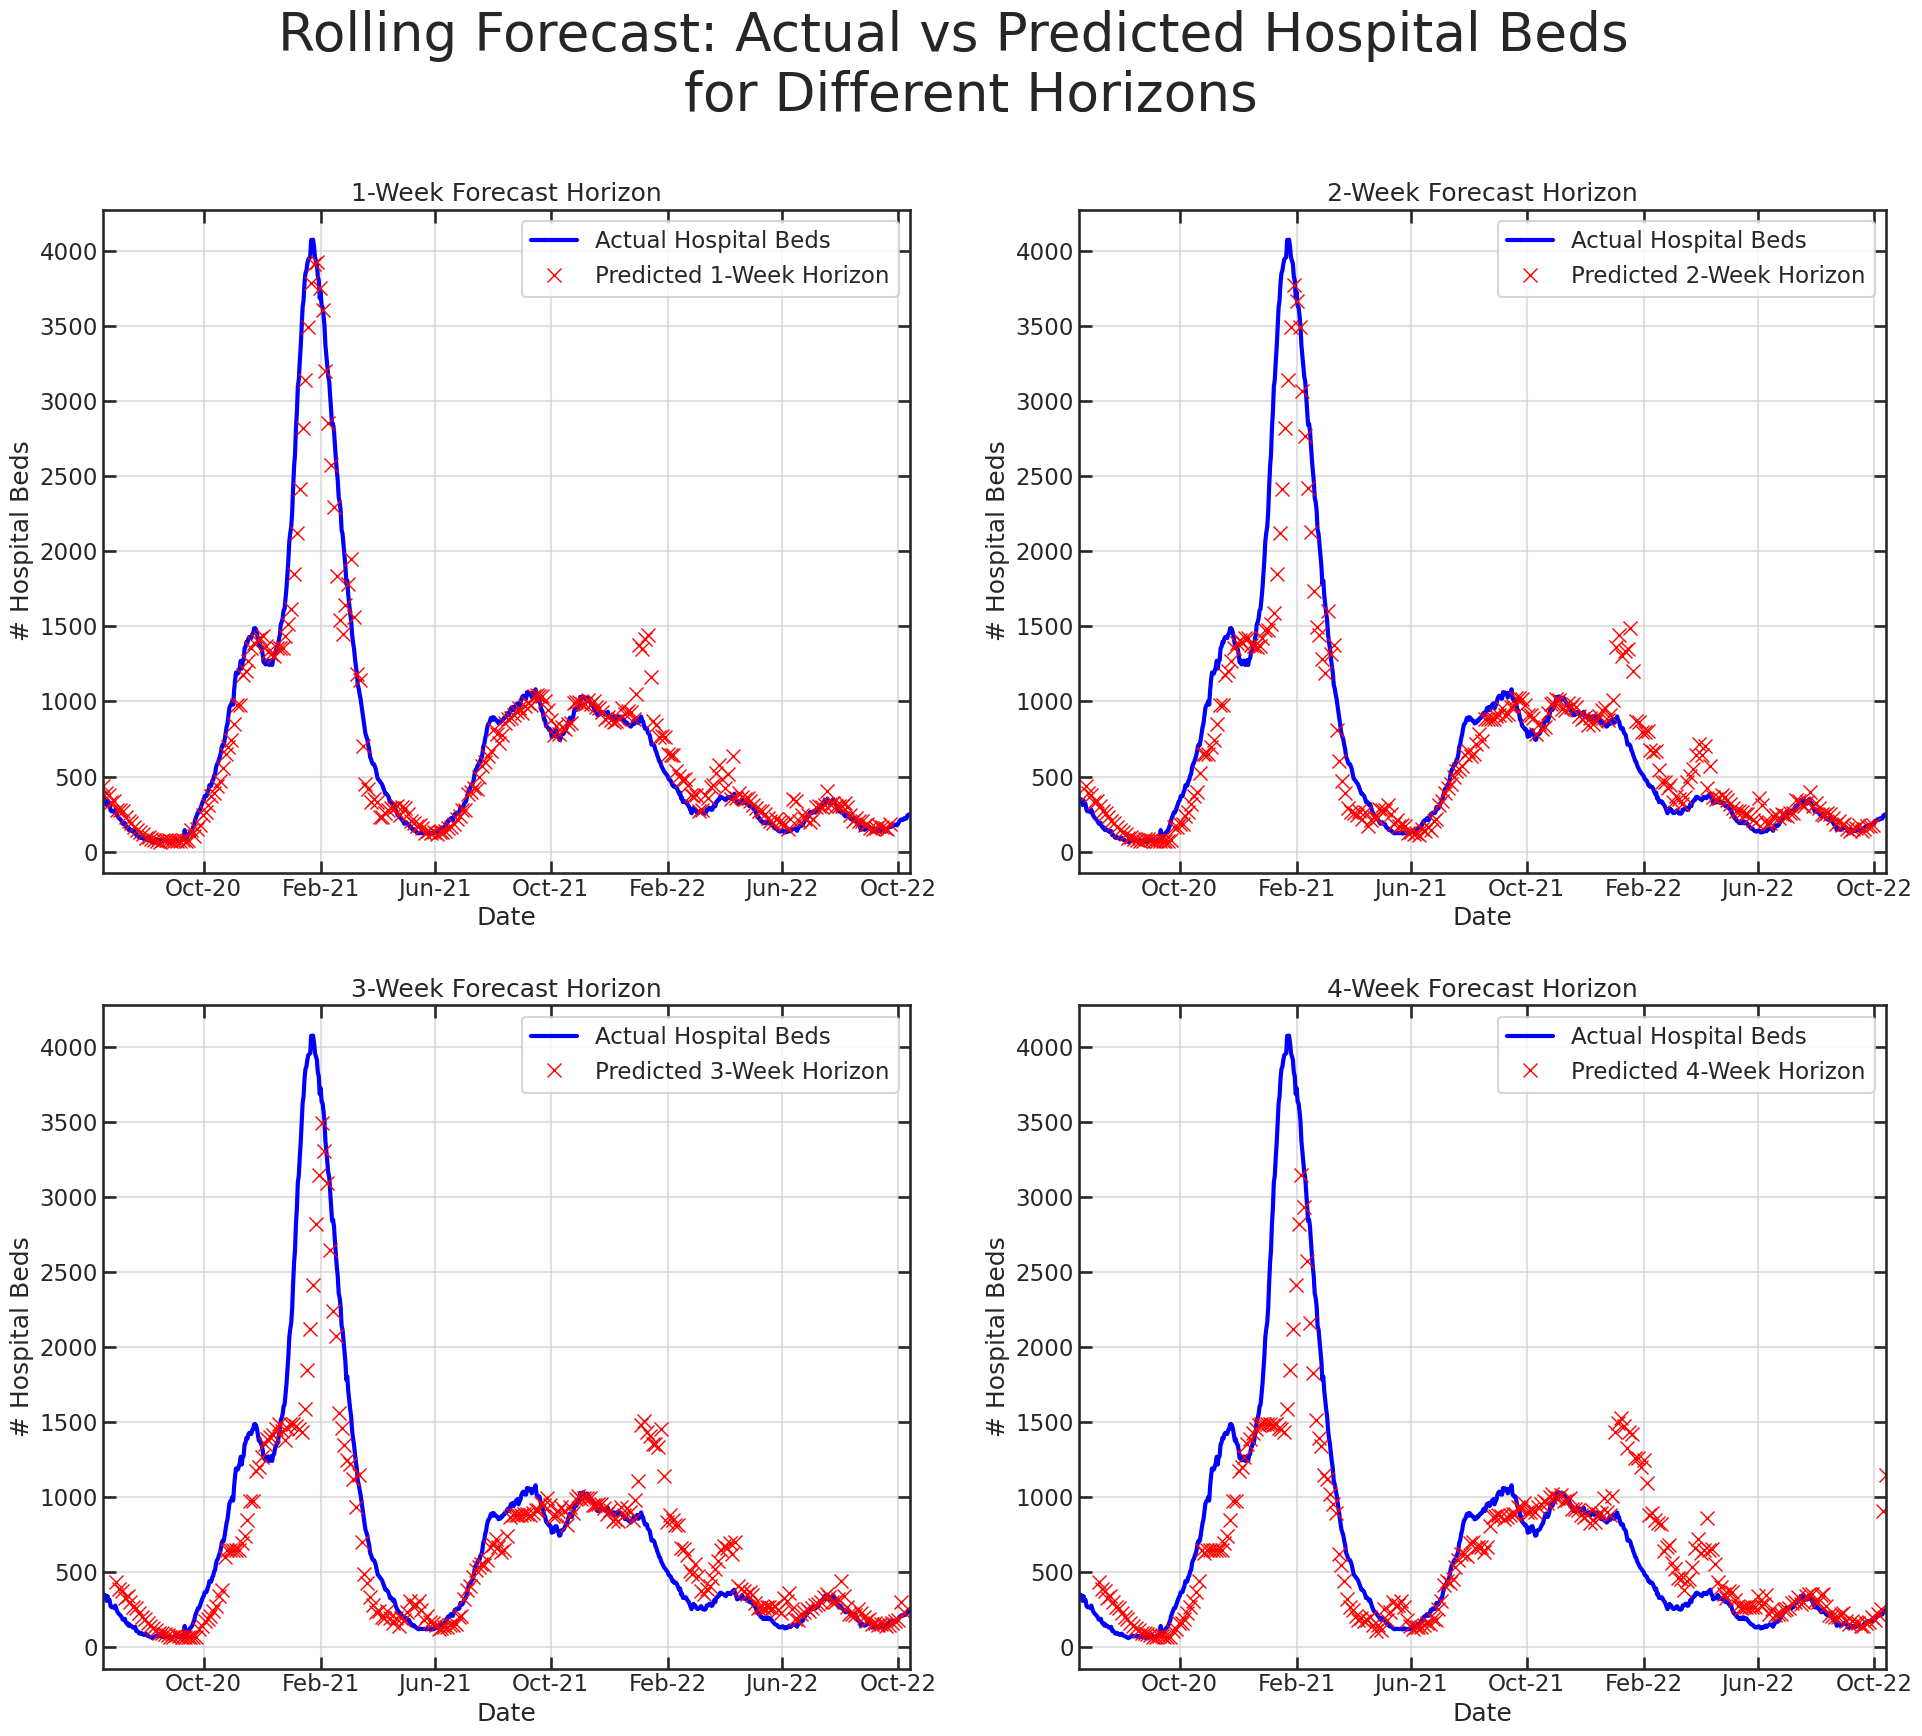

In [107]:
# Syntax: rwf_v1(dataset, target, model_specs, window_size, step_size, forecast_horizons, roll
# Takes a few minutes to run 

window_size = 10
forecast_horizon = 7
forecast_horizons = [forecast_horizon*i for i in range(1,5)]
step_size = 3

target = 'covidOccupiedMVBeds'
forecast = rwf_v1(combined_google, target, (XGBRegressor(), {
        'model__n_estimators': [50, 100],
        'model__max_depth': [5, 15],
        'model__learning_rate': [0.01, 0.2]}),
        window_size, step_size,forecast_horizons, True)

We find that for higher (greater than 1 week) forecast horizons, the model seems to struggle making correct predicitons and its predictions also seem to lag behind the actual values. This is somewhat expected, but it does inevitably lead to the RMSE for higher forecast horizons being worse/higher on average:

In [91]:
forecast_results = pd.DataFrame(list(forecast.items()), columns=["Horizon (Days)", "RMSE"])
forecast_results

,Horizon (Days),RMSE
0,7,190.473765
1,14,293.983622
2,21,387.929497
3,28,465.007655


Note that we tried using the above on the lagged dataset from above, but this resulted in poorer performance, so we will stick to the unlagged version of the data, and discuss the inclusion of lags obtained from correlating the predictors and targets later.

Furthemore, see that from about the start of 2022, the ML model seems to overestimate the number of beds required. This is not due to some sort of 'randomness' and seems to be 'systematic', i.e., this happens consistently over several runs. There is an obvious reason for this: we have not accounted for other metrics, such as, vaccinations, which would lead to decreases in the number of beds and the deaths occurring. We now return to feature selection and engineering to address this issue.

We also need to refine how our model is fitted to the data, so several changes will have to be made to the function `rwf_v1()` and also to how we are pre-processing our data.

## Section 3: Further Feature Selection 
Given that we have developed a rough framework to perform our forecasting task, we turn our attention back to the government datasets. We will, in particular, be looking at the 'Vaccinations' and 'Deaths' folders to find the most important metrics within these folders. We will also look at the remaining folders to see if we might be able to find any useful information within them. We will heavily reference the supporting documentation to pick out the most useful metrics from each folder. We will, as before, try to pick out the most general metrics possible.

#### **Vaccinations**
 We find that the most important metrics here are `'newPeopleVaccinatedCompleteByVaccinationDate', 'newPeopleVaccinatedFirstDoseByVaccinationDate', 'newPeopleVaccinatedSecondDoseByVaccinationDate', 'newPeopleVaccinatedThirdInjectionByVaccinationDate'`.

#### **Deaths**
Again considering very general metrics as we did for the previous folder, the single metric that seems to be the most useful here is: '`newDailyNsoDeathsByDeathDate`'.

#### **Cases**
Proceeding to the 'Cases' data, the significant metric in this folder is `'newCasesBySpecimenDate'`.

#### **Testing**
Including the data from the 'Testing' folder, the important metric here seems to be `newVirusTestsBySpecimenDate`.

#### **Healthcare**
For completeness, and as before, we identify `'covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions'` to be the important metrics here.

We write an overall function that produces one final dataframe including all the relevant metrics:

In [155]:
def all_useful_data(metric_groups):
    overall_data_list = []
    for data_type, metrics in metric_groups.items():
        overall_list = []
        for metric in metrics:
            overall_list.append(reformatter(csvconcat(data_type, metric), metric, 'nation', 'value'))
        combined_df = combiner(overall_list)
        combined_df.columns = metrics
        overall_data_list.append(combined_df)
    overall_data = combiner(overall_data_list)
    return overall_data

This block of code should return a dataframe containing all useful parameters, as well as the Google data. We will also save it locally for faster read-in.

In [156]:
metrics_healthcare = ['covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions']
metrics_vacc = ['newPeopleVaccinatedCompleteByVaccinationDate',
                'newPeopleVaccinatedFirstDoseByVaccinationDate',
                'newPeopleVaccinatedSecondDoseByVaccinationDate',
                'newPeopleVaccinatedThirdInjectionByVaccinationDate']
metrics_deaths = ['newDailyNsoDeathsByDeathDate']
metrics_cases = ['newCasesBySpecimenDate']
metrics_testing = ['newVirusTestsBySpecimenDate']

metric_groups = {
    DataType.Healthcare: metrics_healthcare,
    DataType.Vaccinations: metrics_vacc,
    DataType.Deaths: metrics_deaths,
    DataType.Cases: metrics_cases,
    DataType.Testing: metrics_testing,
}

overall_govt_data_ = all_useful_data(metric_groups)
overall_govt_data = overall_govt_data_.loc[:max(pd.to_datetime(df_google.index, errors = 'coerce')),:]
overall_govt_data.fillna(0, inplace = True)
data_processed = combiner([overall_govt_data, df_google])
data_processed.dropna(inplace = True)
#data_processed.to_csv('data_processed.csv', sep=',', index=True, encoding='utf-8')

/tmp/ipykernel_49438/4052079179.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [157]:
#data_processed = pd.read_csv('data_processed.csv', sep = ',', index_col = 'date')
display(data_processed)

,covidOccupiedMVBeds,hospitalCases,newAdmissions,newPeopleVaccinatedCompleteByVaccinationDate,newPeopleVaccinatedFirstDoseByVaccinationDate,newPeopleVaccinatedSecondDoseByVaccinationDate,newPeopleVaccinatedThirdInjectionByVaccinationDate,newDailyNsoDeathsByDeathDate,newCasesBySpecimenDate,newVirusTestsBySpecimenDate,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,,,,,,,,
2020-06-01,652.0,7171.0,605.0,0.0,0.0,0.0,0.0,199.0,1439.0,51462.0,-56.0,-13.0,74.0,-51.0,-53.0,19.0
2020-06-02,636.0,7014.0,666.0,0.0,0.0,0.0,0.0,233.0,1492.0,63137.0,-59.0,-15.0,78.0,-51.0,-54.0,19.0
2020-06-03,602.0,6750.0,632.0,0.0,0.0,0.0,0.0,203.0,1369.0,67930.0,-62.0,-19.0,0.0,-57.0,-54.0,22.0
2020-06-04,571.0,6525.0,562.0,0.0,0.0,0.0,0.0,183.0,1249.0,65373.0,-61.0,-17.0,19.0,-56.0,-54.0,22.0
2020-06-05,554.0,6325.0,472.0,0.0,0.0,0.0,0.0,184.0,1123.0,70327.0,-63.0,-17.0,9.0,-56.0,-53.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,241.0,12179.0,1243.0,1281.0,910.0,1280.0,4764.0,110.0,9461.0,90914.0,-11.0,7.0,29.0,-21.0,-24.0,5.0
2022-10-12,240.0,12314.0,1189.0,1375.0,1000.0,1370.0,5189.0,127.0,8769.0,88013.0,-11.0,6.0,16.0,-22.0,-24.0,5.0
2022-10-13,248.0,12229.0,1276.0,1423.0,937.0,1361.0,5199.0,112.0,8134.0,85179.0,-9.0,9.0,30.0,-21.0,-24.0,5.0


## Section 4: Updated Model
### Introducing Lagged Predictors
Now that we have obtained all the useful data, we can turn to updating our model so that it makes predictions based on past data **only**. We can clearly see that each **column** of our dataset is a **time series** itself. Now, we would use tree-based models like the ones we have considered so far for classification and regression, but adapting these types of models for **multivariate time series forecasting** (which is what we seem to be doing here), is tricky - more so than what we have implemented so far. Fortunately, we found several webpages that describes very similar methodologies, to varying levels of depth, as the one we are trying to implement: [this](https://machinelearningmastery.com/xgboost-for-time-series-forecasting/), [this](https://www.analyticsvidhya.com/blog/2024/01/xgboost-for-time-series-forecasting/) and [this](https://xgboosting.com/xgboost-add-lagged-input-variables-for-time-series-forecasting/).

The main message is that we simply need to add lagged features to our dataset for each step of the training/testing procedure. This effectively shifts our dataframe in a way such that we can only train on values up to a certain date - `start_index` and then predicts future values for the target metrics. However, since we are interested in making weekly forecasts, we can simply shift the predictor columns down by 28 days beforehand, to produce the same number of new predictor metrics. Then, we can simply pick out the 7th/14th/21st/28th element of the output prediction array giving us the required weekly forecasts. We adopt this **one-shot prediction** technique to maintain speed of execution and efficiency.

We introduce a `create_lag()` function that does this: 

In [158]:
def create_lag(df, cols_to_lag, max_horizon):
    lagged_cols = {}
    new_targets = []
    for col in cols_to_lag:
        lagged_col = f'{col}_lag{max_horizon}'
        lagged_cols[lagged_col] = df[col].shift(max_horizon)
    lagged_df = pd.concat([df, pd.DataFrame(lagged_cols, index=df.index)], axis=1)
    lagged_df.fillna(0, inplace=True)
    return lagged_df

Let us check how this works on our dataframe:

In [159]:
targets=['covidOccupiedMVBeds', 'newDailyNsoDeathsByDeathDate']
preds = [col for col in data_processed.columns if col not in[targets]]
window_size = 10
forecast_horizons = [i*7 for i in range(1,5)]
lagged_df = create_lag(data_processed, preds, max(forecast_horizons))
lagged_df.index = pd.to_datetime(lagged_df.index)
lagged_df['year'] = lagged_df.index.year
lagged_df['month'] = lagged_df.index.month
lagged_df['day'] = lagged_df.index.dayofweek
lagged_df_ohe = lagged_df.copy()
lagged_df_ohe['weekday/weekend'] = lagged_df_ohe.day.map(lambda x: 1 if x<5 else 0)
lagged_df_ohe['weekday'] = lagged_df_ohe['weekday/weekend']
lagged_df_ohe['weekend'] = 1 - lagged_df_ohe['weekday']
lagged_df_ohe.drop(columns=['weekday/weekend', 'weekday'], inplace=True)
display(lagged_df_ohe)

,covidOccupiedMVBeds,hospitalCases,newAdmissions,newPeopleVaccinatedCompleteByVaccinationDate,newPeopleVaccinatedFirstDoseByVaccinationDate,newPeopleVaccinatedSecondDoseByVaccinationDate,newPeopleVaccinatedThirdInjectionByVaccinationDate,newDailyNsoDeathsByDeathDate,newCasesBySpecimenDate,newVirusTestsBySpecimenDate,...,retail_and_recreation_percent_change_from_baseline_lag28,grocery_and_pharmacy_percent_change_from_baseline_lag28,parks_percent_change_from_baseline_lag28,transit_stations_percent_change_from_baseline_lag28,workplaces_percent_change_from_baseline_lag28,residential_percent_change_from_baseline_lag28,year,month,day,weekend
date,,,,,,,,,,,,,,,,,,,,,
2020-06-01,652.0,7171.0,605.0,0.0,0.0,0.0,0.0,199.0,1439.0,51462.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020,6,0,0
2020-06-02,636.0,7014.0,666.0,0.0,0.0,0.0,0.0,233.0,1492.0,63137.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020,6,1,0
2020-06-03,602.0,6750.0,632.0,0.0,0.0,0.0,0.0,203.0,1369.0,67930.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020,6,2,0
2020-06-04,571.0,6525.0,562.0,0.0,0.0,0.0,0.0,183.0,1249.0,65373.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020,6,3,0
2020-06-05,554.0,6325.0,472.0,0.0,0.0,0.0,0.0,184.0,1123.0,70327.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020,6,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,241.0,12179.0,1243.0,1281.0,910.0,1280.0,4764.0,110.0,9461.0,90914.0,...,-11.0,7.0,37.0,-21.0,-27.0,4.0,2022,10,1,0
2022-10-12,240.0,12314.0,1189.0,1375.0,1000.0,1370.0,5189.0,127.0,8769.0,88013.0,...,-10.0,7.0,39.0,-21.0,-26.0,4.0,2022,10,2,0
2022-10-13,248.0,12229.0,1276.0,1423.0,937.0,1361.0,5199.0,112.0,8134.0,85179.0,...,-9.0,9.0,44.0,-23.0,-26.0,4.0,2022,10,3,0


### Extensive Hyperparameter Tuning

We will slightly change the way we tune the hyperparameters of our regressor with the aim of making performance gains. We will use `RandomizedSearchCV()` instead of `GridSearchCV()`, so that we can explore a larger number of hyperparameter combinations faster.

We update our `rwf_v1()` function to accommodate these changes accordingly:

In [160]:
def rwf_v2(lagged_dataset, targets, model_specs, window_size, step_size, forecast_horizons, roll):
    if isinstance(targets, str):
        targets = [targets]
        
    y = lagged_dataset[targets]
    X = lagged_dataset.drop(columns=targets)
    y.index = pd.to_datetime(y.index, errors="coerce")
    
    if y.index.isna().any():
        raise ValueError("Found invalid dates in y.index")
    
    X_rolling = X.rolling(window = window_size, min_periods=1).mean().fillna(0) if roll else X
    
    all_predictions = {target: {h: [] for h in forecast_horizons} for target in targets}
    all_true_values = {target: {h: [] for h in forecast_horizons} for target in targets}
    all_dates = {h: [] for h in forecast_horizons}
    
    start_index = max(forecast_horizons)

    max_steps = len(X) - max(forecast_horizons)
                    
    with tqdm(total = max_steps) as pbar:
        while start_index + max(forecast_horizons) <= len(X):
            if start_index + forecast_horizons[0] > len(X): 
                break
            X_train = X_rolling.iloc[:start_index]
            y_train = y.iloc[:start_index]
            
            pipeline = Pipeline([('scaler', StandardScaler()),
                                 ('model', model_specs[0])])
            
            tscv = TimeSeriesSplit(n_splits=3)
            random_search = RandomizedSearchCV(
                pipeline,
                param_distributions=model_specs[1],
                n_iter=15,
                cv=TimeSeriesSplit(n_splits=3),
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                verbose=0,
            ) 
            
            random_search.fit(X_train, y_train)
            best_model = random_search.best_estimator_
            X_test = X_rolling.iloc[start_index: start_index + max(forecast_horizons)]
            y_test = y.iloc[start_index:start_index + max(forecast_horizons)]
            y_pred = best_model.predict(X_test)
            for horizon in forecast_horizons:
                if start_index + horizon > len(X): 
                        continue
                all_dates[horizon].extend([pd.to_datetime(y.index[start_index + horizon - 1])])
                for i,target in enumerate(targets):
                    if len(targets) == 1:
                        all_predictions[target][horizon].extend([y_pred[horizon-1]])
                        all_true_values[target][horizon].extend([y_test.iloc[horizon-1]]) 
                    else:
                        all_predictions[target][horizon].extend([y_pred[horizon-1][i]])
                        all_true_values[target][horizon].extend([y_test.iloc[horizon-1,i]]) 
                
            start_index += step_size
            pbar.update(step_size)

    rmses = {}
    for target in targets:
        for horizon in forecast_horizons:
            rmses[(target,horizon)] = root_mean_squared_error(all_true_values[target][horizon], all_predictions[target][horizon])

    return all_dates, all_true_values, all_predictions, rmses 

We have now included the ability to handle multiple target variables and have also updated some aspects of the logic here, to ensure leakage of future data into the current train-test dataset. The lagged input dataset automatically facilitates this. We have also included the fact that we can perform a one-shot prediction for the next 28 days at once, picking out values from the prediction array corresponding to multiples of 7. We have also changed the functionality of the `window_size` parameter, so that now it only affects the range over which the data is smoothed.

We have separated out plotting functionality (see below), and are now returning the `dict`'s `all_dates`, `all_true_values`
, `all_predictions`, `rmses`. There are some differences from before:

- `all_true_values`: a dict with `len(targets)` keys. Each of these keys in turn corresponds to a `dict` which have the same keys as `all_dates` above, but the item corresponding to that key is the list of true values of the target metric 7 days after the point of training. E.g. `{Beds: {7: [true value of target 7 days after point of training], 14: [...], ...}, Deaths: {7: [...], ...}}`.
- `all_predictions`: the same as `all_true_values` except that the inner lists contain predicted values rather than true value. E.g. `{Beds: {7: [predicted value of target 7 days after point of training], 14: [...], ...}, Deaths: {7: [...], ...}}` 

Now, upgrade our plotting functionalities from before to facilitate greater interactivity with the data and predictions. Below we make a new plotting function, `interactive_plot()`. This function makes heavy use of `plotly` and took quite some time to formulate in its current form. The output could be a bit better as will be shown below.

In [161]:
import plotly.graph_objects as go

def interactive_plot(dataset, all_predictions, all_true_values, all_dates, rmses, targets, forecast_horizons):
    fig = go.Figure()
    traces = []

    for target_idx, target in enumerate(targets):
        true_trace = go.Scatter(
            x=all_dates[forecast_horizons[0]],
            y=all_true_values[target][forecast_horizons[0]],
            mode='lines',
            name=f"{target} - True Values",
            visible=(target_idx == 0),
        )
        traces.append(true_trace)

        for horizon in forecast_horizons:
            pred_trace = go.Scatter(
                x=all_dates[horizon],
                y=all_predictions[target][horizon],
                mode='markers',
                name=f"{target} - {horizon} Days \n(RMSE: {rmses[(target,horizon)]:.1f})",
                visible=(target_idx == 0)
            )
            traces.append(pred_trace)

    for trace in traces:
        fig.add_trace(trace)
        
    buttons = []
    for target_idx, target in enumerate(targets):
        visibility = [t.name.startswith(f"{target} -") for t in traces]
        
        buttons.append(dict(label=target, method="update", args=[{"visible": visibility}]))

    start_date = min(all_dates[forecast_horizons[0]])
    end_date = max(all_dates[forecast_horizons[0]])
    fig.update_layout(
        updatemenus=[
            dict(
                type="dropdown",
                direction="down",
                buttons=buttons,
                showactive=True,
                x=1,
                y=1,
                font=dict(size=20)
            ),
        ],
        title=dict(
            text="Forecast Plots of Target Metrics Over the COVID-19 Pandemic",
            x=0.5,
            xanchor="center",
            y=0.95,
            yanchor="top"
        ),
        xaxis=dict(
            title = 'Date',
            title_standoff=10, 
            rangeslider=dict(
                visible=True,
                thickness=0.1,
                range=[start_date, end_date]
            ),
            rangeselector=dict(
                buttons=[
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all"),
                ]
            ),
        ),
        yaxis_title="Value of Target Metric",
        width=1200,
        height=900,
        legend=dict(
            x=0.5,
            y=-0.4,
            xanchor="center",
            orientation="h",
            font=dict(size=12),
        ),
    )

    return fig

## Section 5: Predictions and Errors

Now we can perform a final run, performing extensive hyperparameter tuning during the run and visualise the results afterwards. Note that this run takes longer than before, taking around 25-30 minutes to execute overall.

In [162]:
model_specs_list = [
    (XGBRegressor(), {
        'model__n_estimators': randint(100, 1000),
        'model__learning_rate': uniform(0.01, 0.3),
        'model__max_depth': randint(3, 10),
        'model__min_child_weight': randint(1, 10),
        'model__subsample': uniform(0, 1),
        'model__colsample_bytree': uniform(0, 1),
        'model__gamma': uniform(0, 1),
        'model__reg_alpha': uniform(0, 0.1),
        'model__reg_lambda': randint(1, 100)})]

In [163]:
window_size = 7
forecast_horizon = 7
forecast_horizons = [forecast_horizon*i for i in range(1,5)]
step_size = 3

targets=['covidOccupiedMVBeds', 'newDailyNsoDeathsByDeathDate']

all_dates, all_true_values, all_predictions, rmses = rwf_v2(lagged_df_ohe, 
                                                           targets,
                                                           model_specs_list[0], 
                                                           window_size, 
                                                           step_size, 
                                                           forecast_horizons, 
                                                           True)

 97%|████████████████████████████████████████████████████████████████████▊  | 813/839 [24:43<00:47,  1.82s/it]


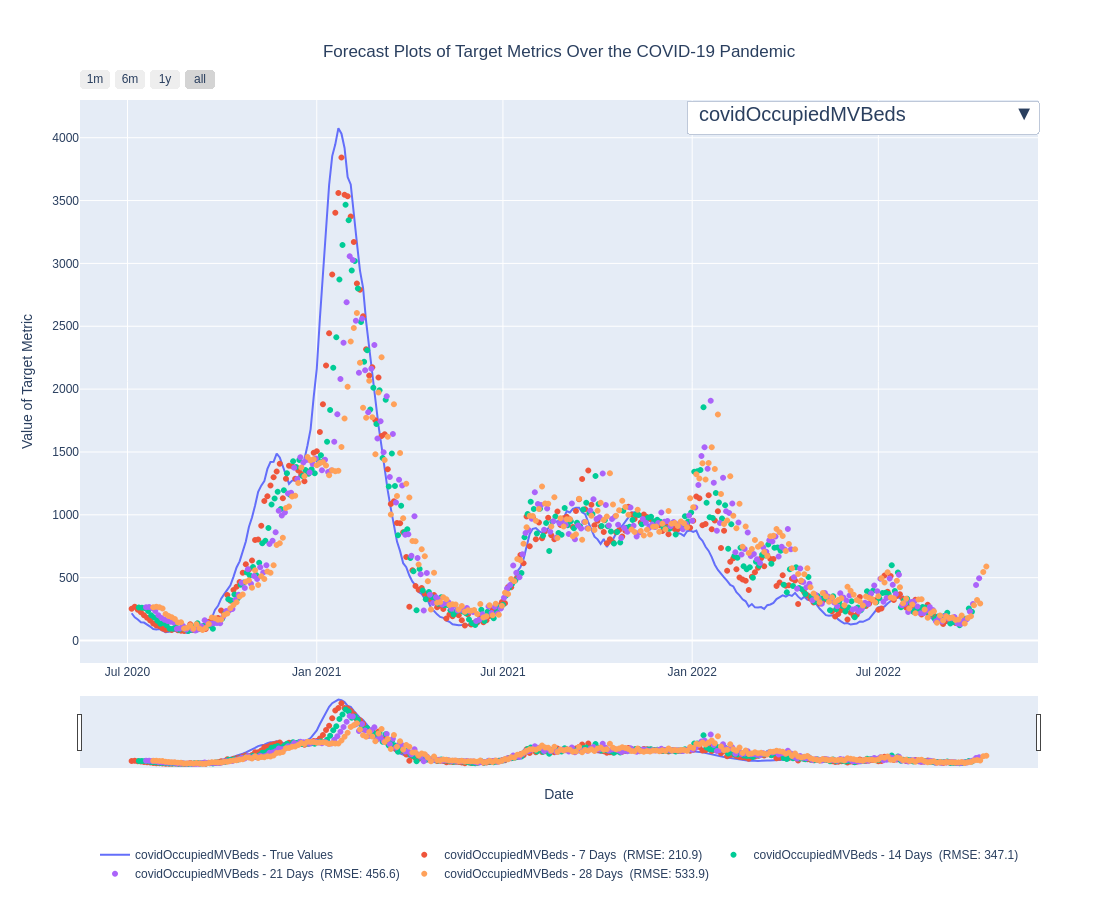

In [164]:
fig = interactive_plot(lagged_df_ohe, all_predictions, all_true_values, all_dates, rmses, targets, forecast_horizons)
fig.show()

The plot above features a drop-down box from which the target metric of interest can be selected. Picking one of these displays the true values of the chosen target variable over the entire COVID-19 pandemic period (solid line) and the respective values of the variable predicted by the model upto 1, 2, 3, 4 week(s) after a given date up to which the model was trained. The individual plots can be toggled on/off, so that, e.g. predictions for different forecast horizons can be compared against each other, as well as the true value of the metric. One can freely pan and zoom the plot, and double-clicking on the plot after any such action will recentre/reset it. We have also included a sliding window on the bottom which can be used to show predictions made from a point to some point in the future.

Note, we acknowledge that the legend looks a bit cluttered with so many instances of the metric name in it. However, we did not find a satisfactory way to drop the metric name from the legend without completely breaking how the code works. The above is simply the best we could manage, though we are certain there must a be way to achieve the stated outcome.

We see that our model does fairly well in predicting both target variables, particularly for shorter forecast horizons, but there is room for improvement. Towards the end of our period of interest especially, we find that the inclusion of additional features has helped somewhat, but the sudden spikes in the values of beds and deaths, from 2022 onwards, have made it difficult for our model to accurately predict the target metrics.

Let us consider some of the error metrics in more detail. First, let us package up the predicted results and true values into dataframes, and save them locally. We will make a function `create_targets()` to do this:

In [168]:
def create_targets(all_predictions, all_true_values, all_dates, targets, forecast_horizons):
    target_dataframes = {}
    
    for target in targets:
        target_dataframes[target] = {}
        for horizon in forecast_horizons:
            df = pd.DataFrame({
                'true_value': all_true_values[target][horizon],
                'predicted_value': all_predictions[target][horizon]
            }, index=pd.to_datetime(all_dates[horizon]))
            
            target_dataframes[target][horizon] = df
            df.to_csv(f'{target}_{horizon}.csv', sep = ',', index = True, encoding = 'utf-8')
    return target_dataframes

We will also create a function `performance_metrics()` that returns a dataframe of several performance metrics for each horizon, for each target:

In [169]:
def performance_metrics(all_predictions, all_true_values, forecast_horizons, targets):
    metrics = {
        'RMSE': lambda y_true, y_pred: root_mean_squared_error(y_true, y_pred),
        'MSE': mean_squared_error,
        'MAE': mean_absolute_error,
    }
    
    performance_dataframes = {}
    
    for target in targets:
        performance_data = {horizon: {} for horizon in forecast_horizons}
        
        for horizon in forecast_horizons:
            y_true = np.array(all_true_values[target][horizon])
            y_pred = np.array(all_predictions[target][horizon])
            
            for metric_name, metric_func in metrics.items():
                performance_data[horizon][metric_name] = metric_func(y_true, y_pred)
        
        performance_df = pd.DataFrame(performance_data).T
        performance_df.columns.name = f'{target}'
        performance_df.index.name = 'Horizon (Days)'
        performance_dataframes[target] = performance_df
        display(performance_df)
        performance_df.to_csv(f'{target}_performance_metrics.csv', sep=',', encoding='utf-8')
    return performance_dataframes

Here, the performance metrics being considered are: the **root-mean-squared-error (RMSE)**, **the mean-squared-error (MSE)**, and the **mean-absoulute-error (MAE)**.

In [170]:
targets=['covidOccupiedMVBeds', 'newDailyNsoDeathsByDeathDate']
forecast_horizons = [forecast_horizon*i for i in range(1,5)]

target_df = create_target_dataframes(
    all_predictions=all_predictions,
    all_true_values=all_true_values,
    all_dates=all_dates,
    targets=targets,
    forecast_horizons=forecast_horizons
)
performance_df = performance_metrics(
    all_predictions=all_predictions,
    all_true_values=all_true_values,
    forecast_horizons=forecast_horizons,
    targets=targets
)

covidOccupiedMVBeds,RMSE,MSE,MAE
Horizon (Days),,,
7,210.856041,44460.270203,126.876999
14,347.070253,120457.760667,201.588883
21,456.630914,208511.791182,261.530067
28,533.883452,285031.540538,308.169949


newDailyNsoDeathsByDeathDate,RMSE,MSE,MAE
Horizon (Days),,,
7,91.800685,8427.365820,54.761613
14,131.038464,17171.079069,75.037360
21,160.941961,25902.314677,94.235872
28,180.317965,32514.568472,103.757001


As expected, the model performs better for short-term predictions but struggles to forecast further into the future. However, the significant difference between RMSE and MAE suggests the presence of outliers that are skewing the predictions. This could also indicate that the time series data is non-stationary, meaning the relationships between variables change over time. To improve model performance, additional steps may be required to account for seasonality or trends within the data. The high sensitivity of MSE to outliers is likely contributing to the large values observed here.

## Section 6: Conclusion

In summary, in this notebook, we:

- utilised the data collected by the UK government and Google to predict the number of hospital beds needed and the number of deaths that will occur up to 28 days from a given date during the pandemic, in intervals of 7 days. 

- commenced by constructed a simple framework to perform the analysis on a subset of the available data to see if we can predict just the number of beds in the future, ensuring that cross-validation was performed at each iteration to enable dynamical updates to the model hyperparameters using `GridSearchCV()`. We expanded this by incorporating by allowing for multi-target forecasting and enabled extensive hyperparameter tuning by opting to use `RandomizedSearchCV()` instead.

- used `XGBRegressor` to perform this analysis incorporated lagged predictors to ensure that there are no instances of future data leaking into the dataset used for training.

- made use of a **one-shot** prediction technique, predicting the values of our target metrics for every day up to 28 days after the point of training, and selecting the required values at 7/14/21/28 days from the point of training.

- made interactive plots that showed the results of the forecasting procedure for each target variable, and all forecast horizons considered for each variable.

- quanitfied the error in forecasting using several performance metrics.

While `XGBoost` is a powerful algorithm in general, we found that, in this case, it struggled to model certain aspects of the target's time series, such as sharp peaks and rapid fluctuations. We have attempted to make the framework presented here as flexible as possible so that it extensions can be made easily. In terms of next steps and improvements to the presented framework, there are several possible options:

- Generally speaking, one can perform more extensive testing with more sets of input parameters. E.g. one can consider the effects of smoothing more carefully, since using/not using `roll` in our functions produces a noticable difference in the performace of the model. One can consider different smoothing windows, or could pre-smooth the dataset before calling the function on it. The same can also be said for the step size.

- Performing a more thorough analysis of features and their importance using methods such as **Principal Component Analysis (PCA)** and extending our existing framework by incorporating PCA, so that the importance of all the metrics can be dynamically assessed during each iteration. This would be computationally expensive, but would likely result in the best performance.

- Considering the lagged effects of predictors on targets more carefully. We performed some preliminary cross-correlation analysis to find the lags between one of the predictors changing and that change affecting the target variable. We did not adopt this methodolgy in the final analysis, since we found that it resulted in poorer performance of the regressor. However, one could include this in our framework such that the correlation between targets and predictors are calculated dynamically and incorporated into how the dataset is lagged. Again, this would be very expensive computationally, but might yield greater insight into how the correlations between variables evolve over time.

- Exploring the usage of other models. We restricted our attention to `XGBRegressor` because we lacked familiarity with this model and we wanted to learn how to use this powerful algorithm. We tried using simpler regression techniques such as linear/polynomial regression. However, perhaps due to how we were pre-processing the data, the performance of these models were lacking severely, and hence we decided not to include them here. There are several other suitable models that may be used here, such as the neural network-based LSTM, or statistical autoregressive models like SARIMAX or Meta's Prophet model. These would likely result in improved forecasting efficiency.

Lastly, we have also made a GitHub [repo](https://github.com/farhansharif75/Time-Series-Forecasting-COVID-Pandemic/tree/main) for this notebook, where this notebook and all the files generated have been uploaded (this was done after the deadline for the assignment had already passed). This brings us to the end of this notebook.